# Maksymilian Wojnar

# Preprocessing obrazu

In [1]:
from collections import Counter
from itertools import product
from matplotlib import pyplot as plt
from numpy.fft import fft2, ifft2
from numpy import rot90
from sklearn import svm
import numpy as np
import cv2

plt.rcParams['figure.figsize'] = [10.0, 8.0]
plt.rcParams['figure.dpi'] = 200

W pierwszej kolejności wczytuję obraz oraz przekształcam go do skali szarości. Zmniejszam też rozmiar obrazu, jeśli jest on za duży, aby przyspieszyć przetwarzanie.

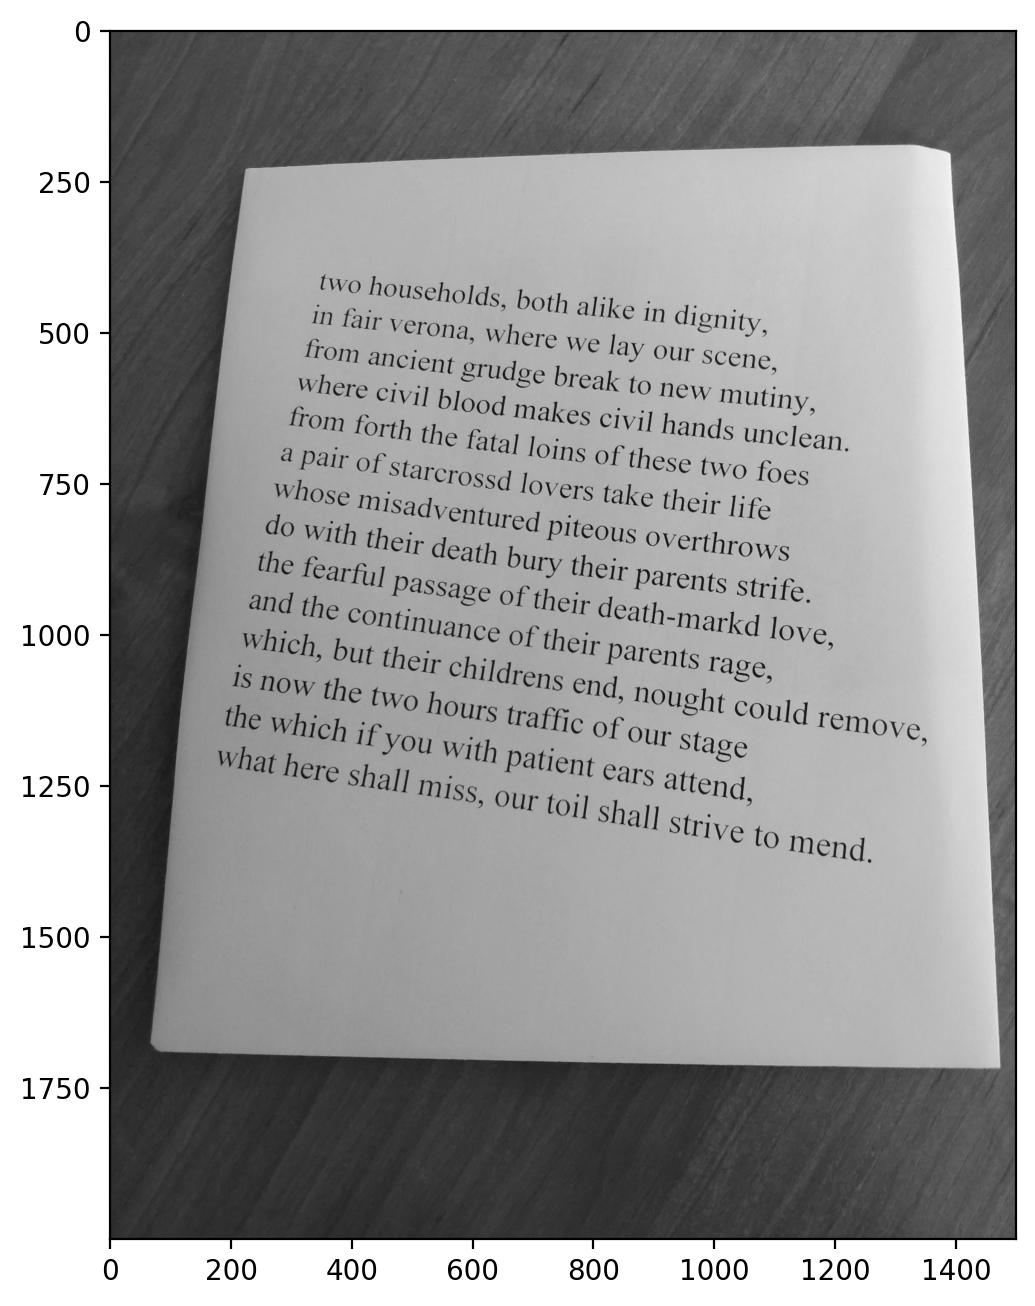

In [2]:
img = cv2.imread('images/romeo_and_juliet.jpg', cv2.IMREAD_GRAYSCALE)

if img.shape[1] > 2000:
    scale = 2000 / img.shape[0]
    img = cv2.resize(img, (0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
elif img.shape[0] > 2000:
    scale = 2000 / img.shape[1]
    img = cv2.resize(img, (0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)

plt.imshow(img, cmap='gray')
plt.show()

Obraz mógł zostać zeskanowany na wyróżniającym się tle lub pod kątem, co tworzy dodatkową ramkę oraz perspektywę na zdjęciu. Wyszukuję zatem czworokąt, w którym znajduje się interesujący nas obszar z tekstem.

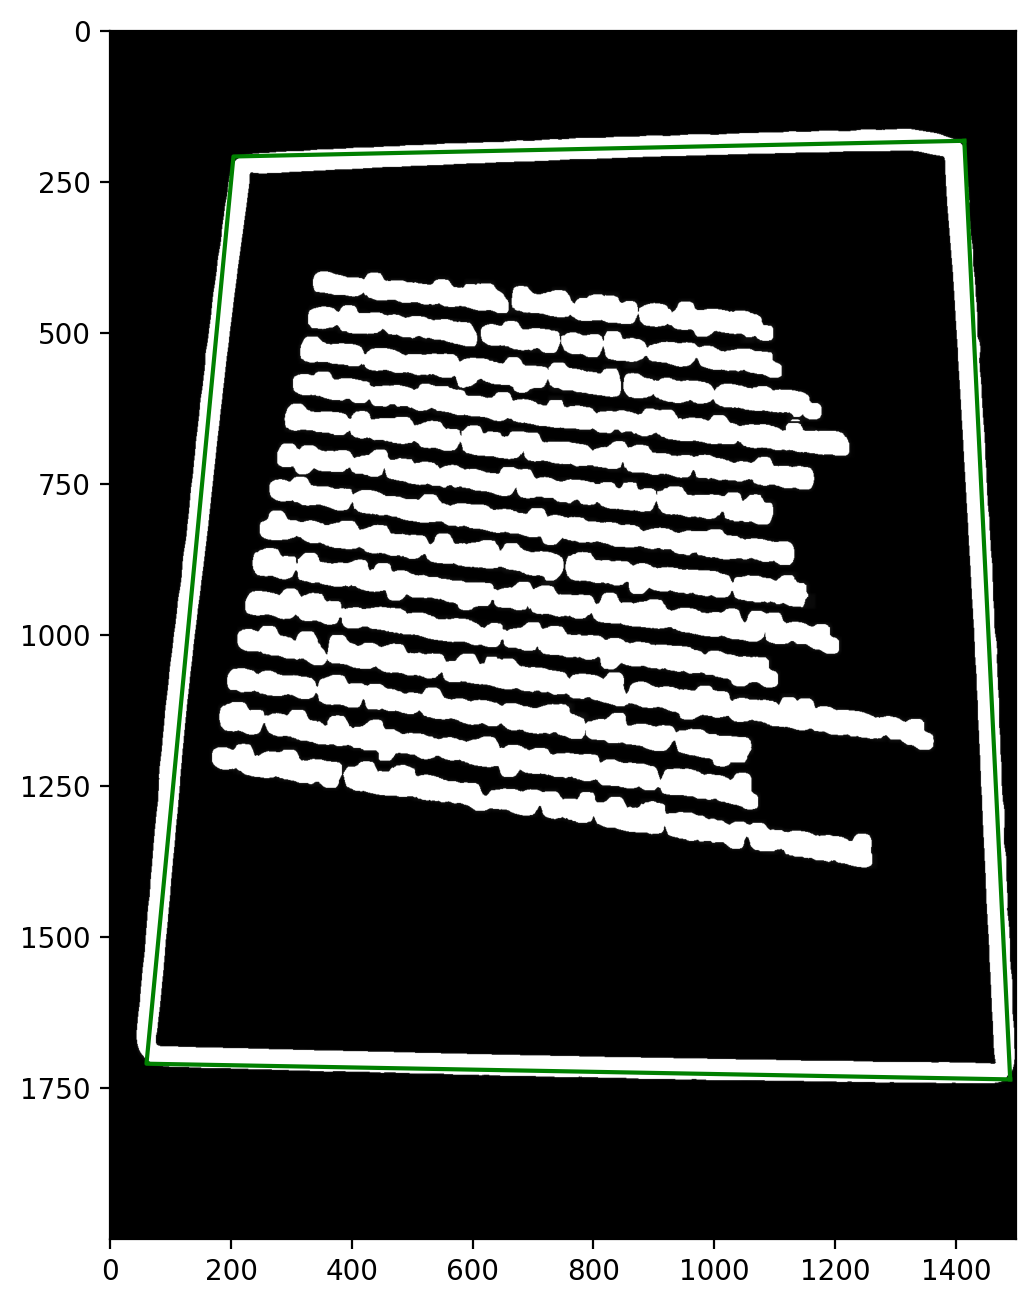

In [3]:
blurred = cv2.bilateralFilter(img, 20, 150, 150)
blurred = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 25, 5)
blurred = cv2.GaussianBlur(blurred, (25, 25), 25)
blurred[blurred > 20] = 255

contours, hierarchy = cv2.findContours(blurred, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
contours = max(contours, key=cv2.contourArea)
x, y, w, h = cv2.boundingRect(contours)

quad = []
eps = 5

while len(quad) != 4:
    quad = np.float32(cv2.approxPolyDP(contours, eps, True))
    eps += 5

plt.imshow(blurred, cmap='gray')
plt.plot(quad[:, 0, 0], quad[:, 0, 1], c='g')
plt.plot([quad[0, 0, 0], quad[-1, 0, 0]], [quad[0, 0, 1], quad[-1, 0, 1]], c='g')
plt.show()

Koryguję teraz perspektywę oraz wycinam ramkę przez przekształcenie czworokąta do prostokąta zajmującego całą powierzchnię obrazu.

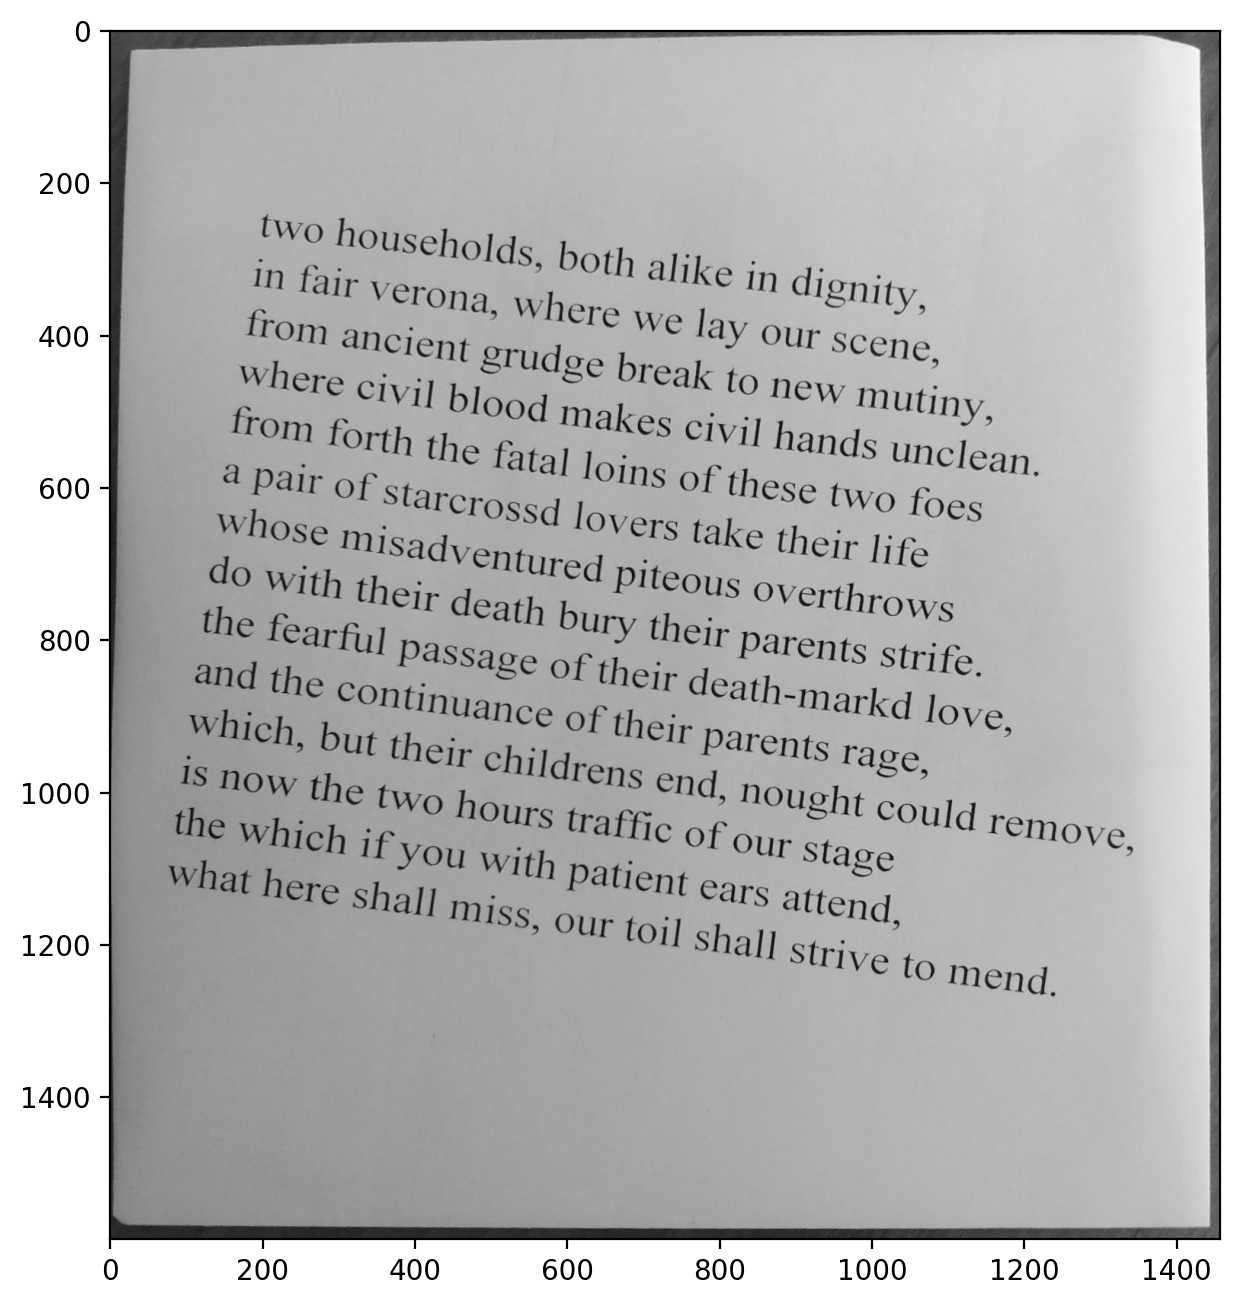

In [4]:
points = [[0, 0], [0, h], [w, h], [w, 0]]
rect = []

for q in quad:
    dists = [(points[i][0] - q[0][0]) ** 2 + (points[i][1] - q[0][1]) ** 2 for i in range(len(points))]
    rect.append([points[np.argmin(dists)]])

rect = np.array(rect, dtype=np.float32)

M = cv2.getPerspectiveTransform(quad, rect)
img = cv2.warpPerspective(img, M, (w, h), flags=cv2.INTER_LINEAR)

plt.imshow(img, cmap='gray')
plt.show()

Ponieważ na obrazie może znajdować się dużo szumu, stosuję filtr odszumiający, a także filtr rozmywający. Bilateral filter pozwala na dobre rozmycie tła z jednoczesnym zachowaniem konturów liter.

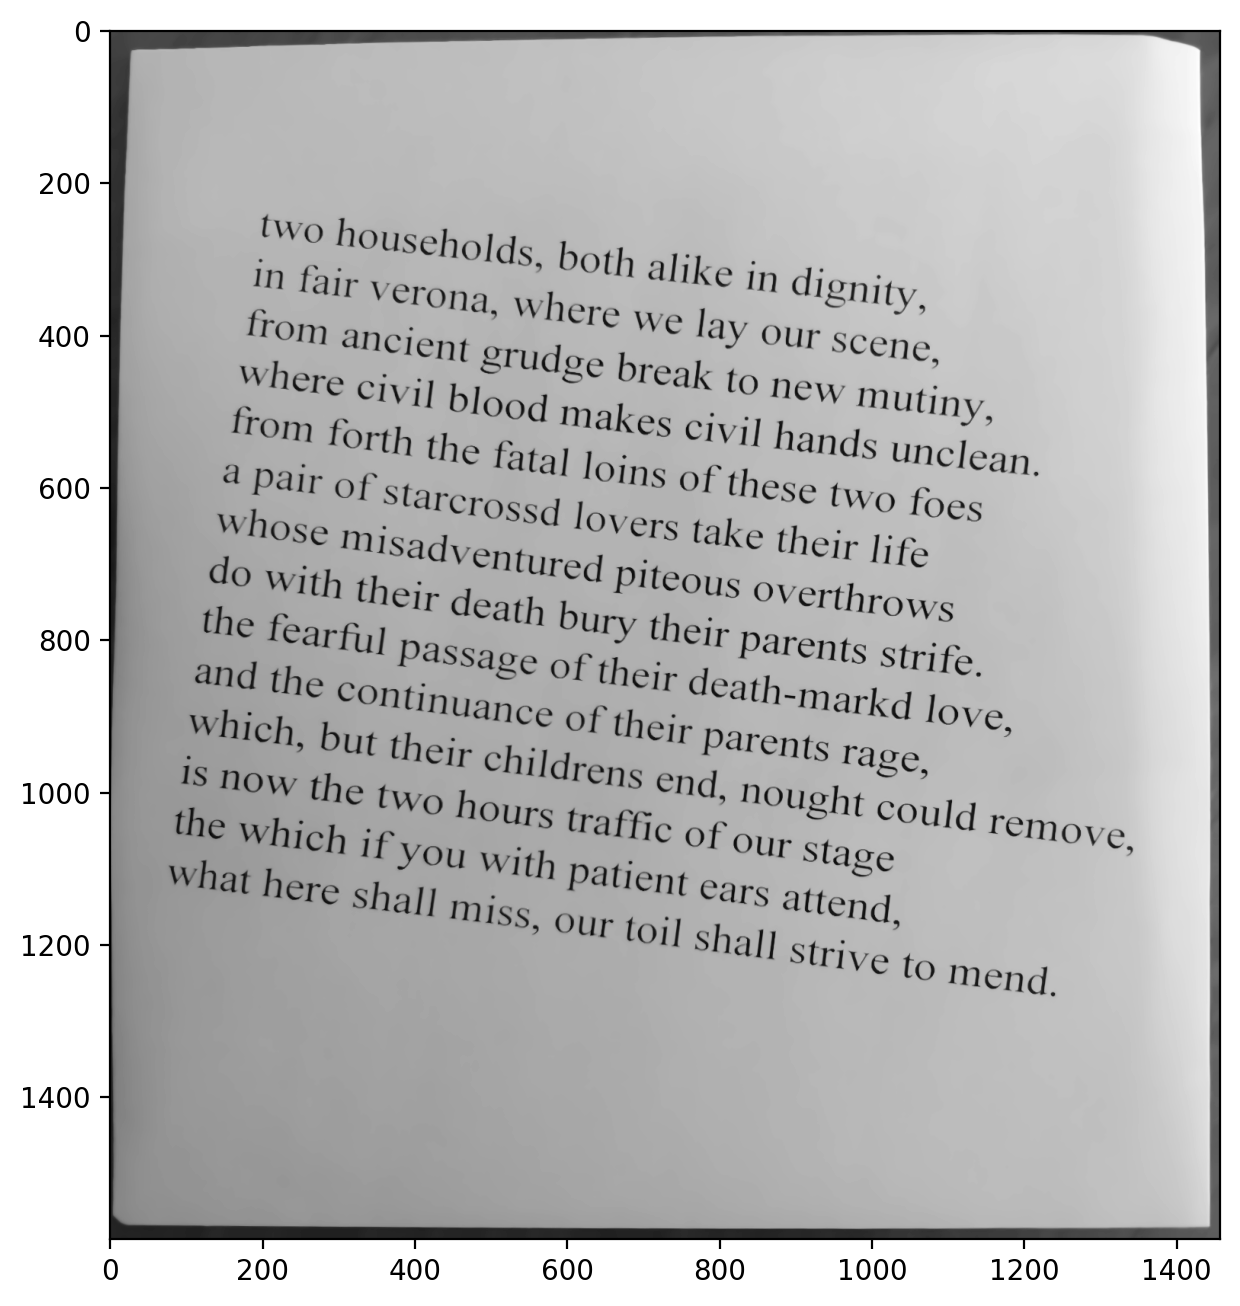

In [5]:
img = cv2.fastNlMeansDenoising(img, None, 9, 7, 21)
img = cv2.bilateralFilter(img, 5, 20, 20)

plt.imshow(img, cmap='gray')
plt.show()

Stosuję adaptive threshold w procesie binaryzacji obrazu. Dzięki zastosowaniu tej techniki, tekst jest dobrze wyróżniony spośród tła, nawet przy zmiennej jasności i nierównomiernym oświelteniu. Adaptive threshold bierze pod uwagę sąsiadujące piksele podczas wyznaczania wartości granicznej w binaryzacji. Jednocześnie odwracam na obrazie kolory - czarne tło, białe litery.

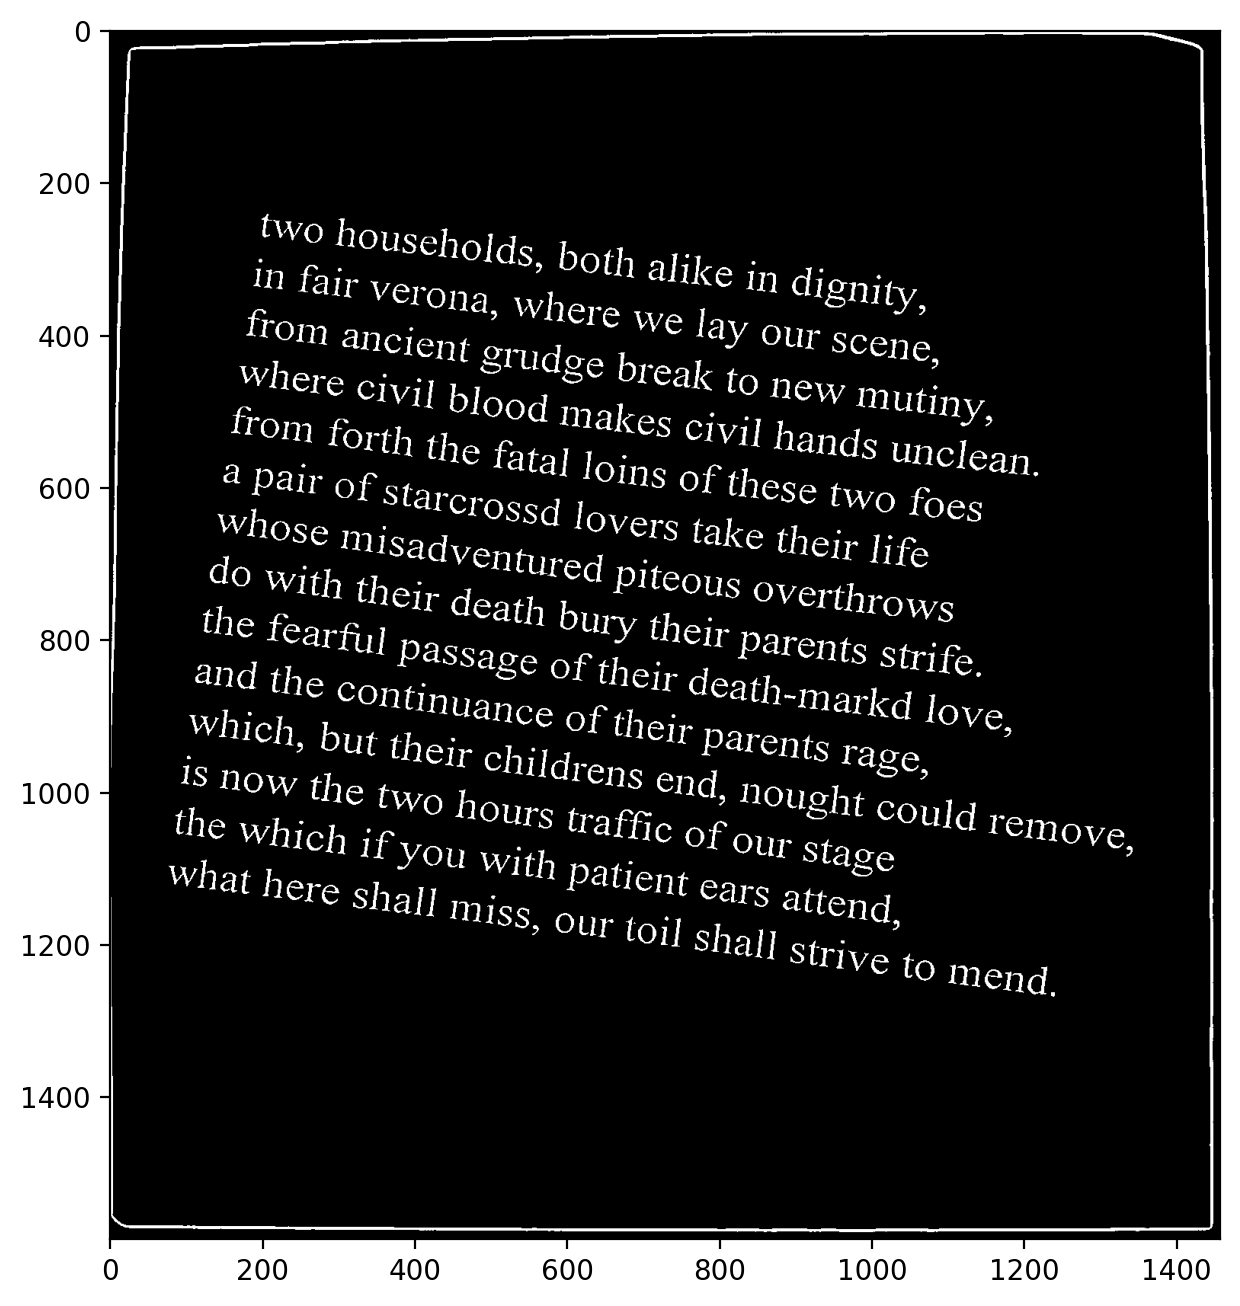

In [6]:
img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 15, 7)

plt.imshow(img, cmap='gray')
plt.show()

Na obrazie mogą występować pozostałości po ramce, dlatego czasami obraz należy przyciąć. Ramki wykrywam przez sumowanie pikseli zbinaryzowanego obrazu oraz sprawdzenie czy występują w sumie bardzo wysokie piki sugerujące ciągłe linie na obrazie.

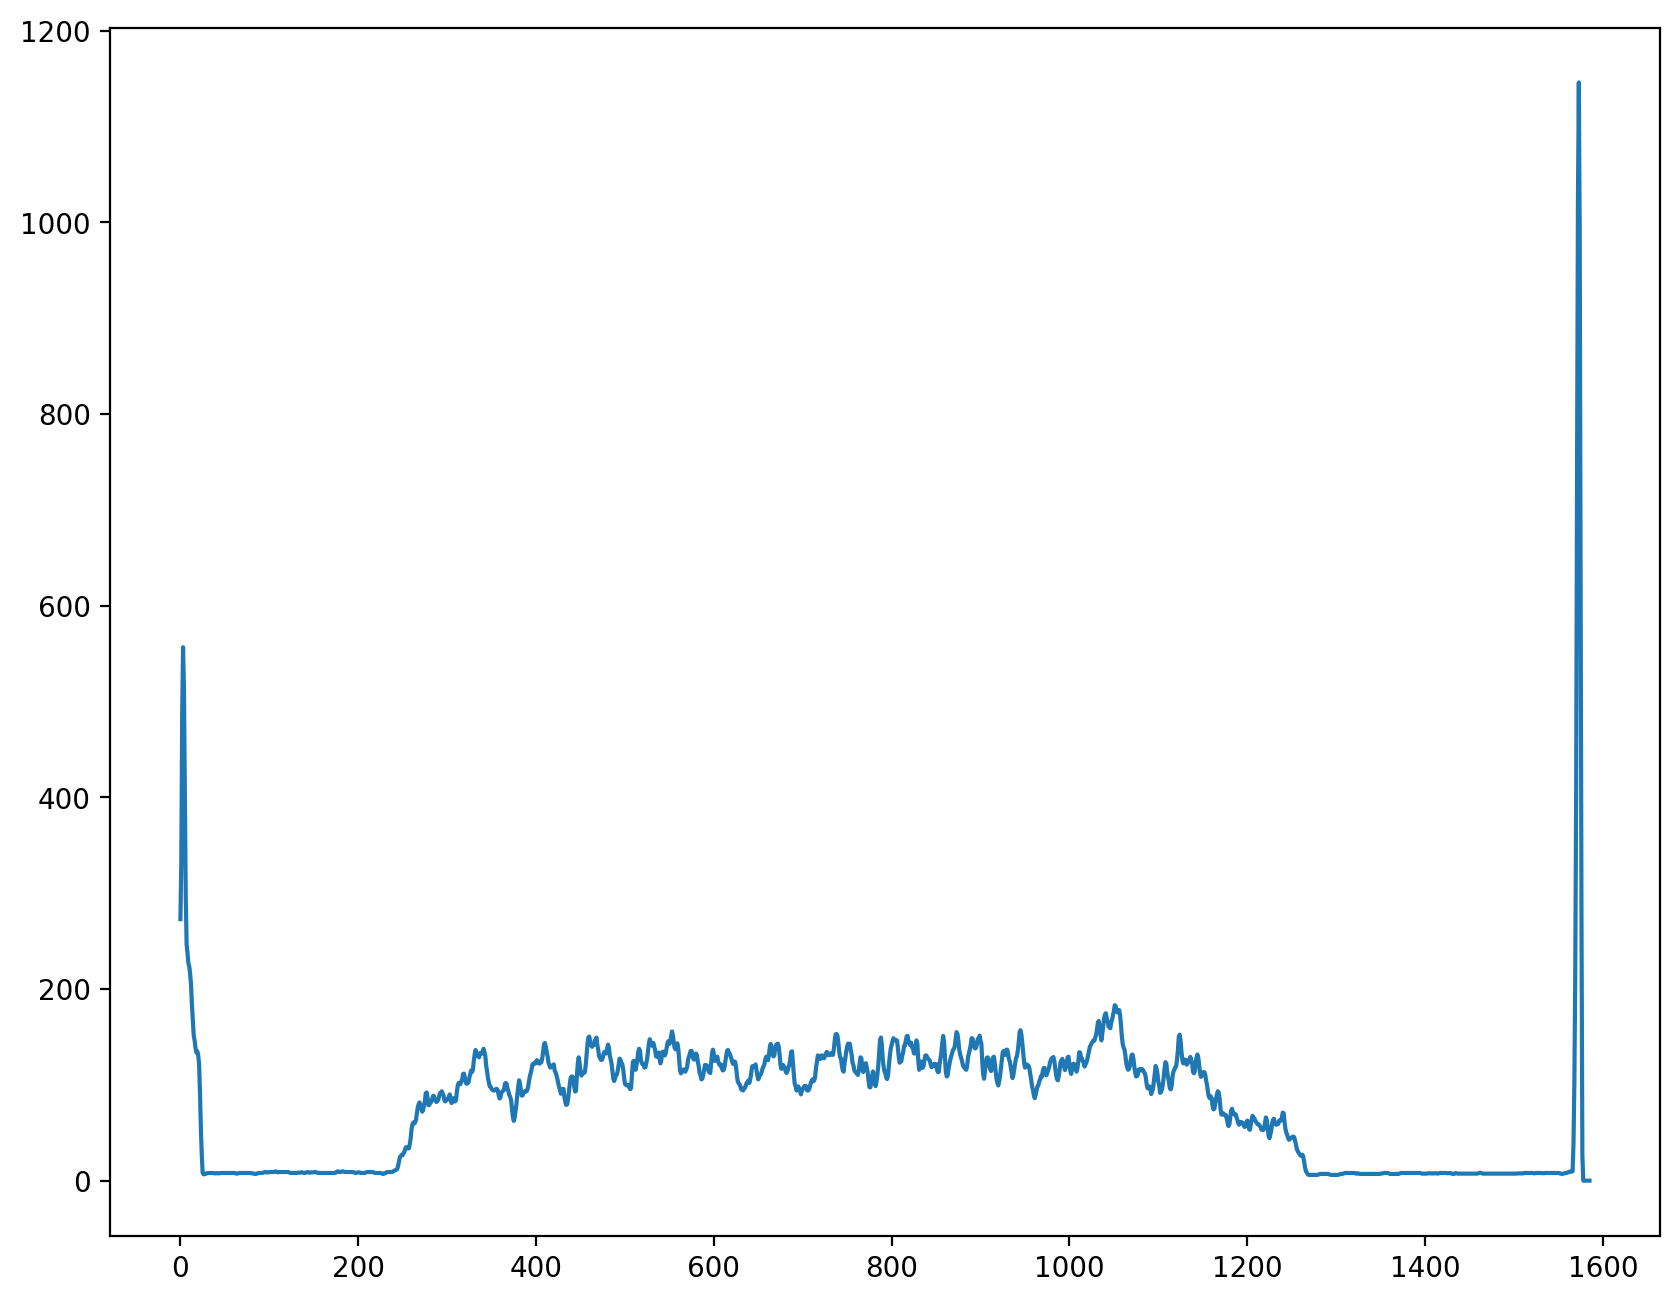

In [7]:
blurred = cv2.GaussianBlur(img, (3, 3), 5)
rows_sum = np.sum(blurred, axis=1) / 255
plt.plot(rows_sum)
plt.show()

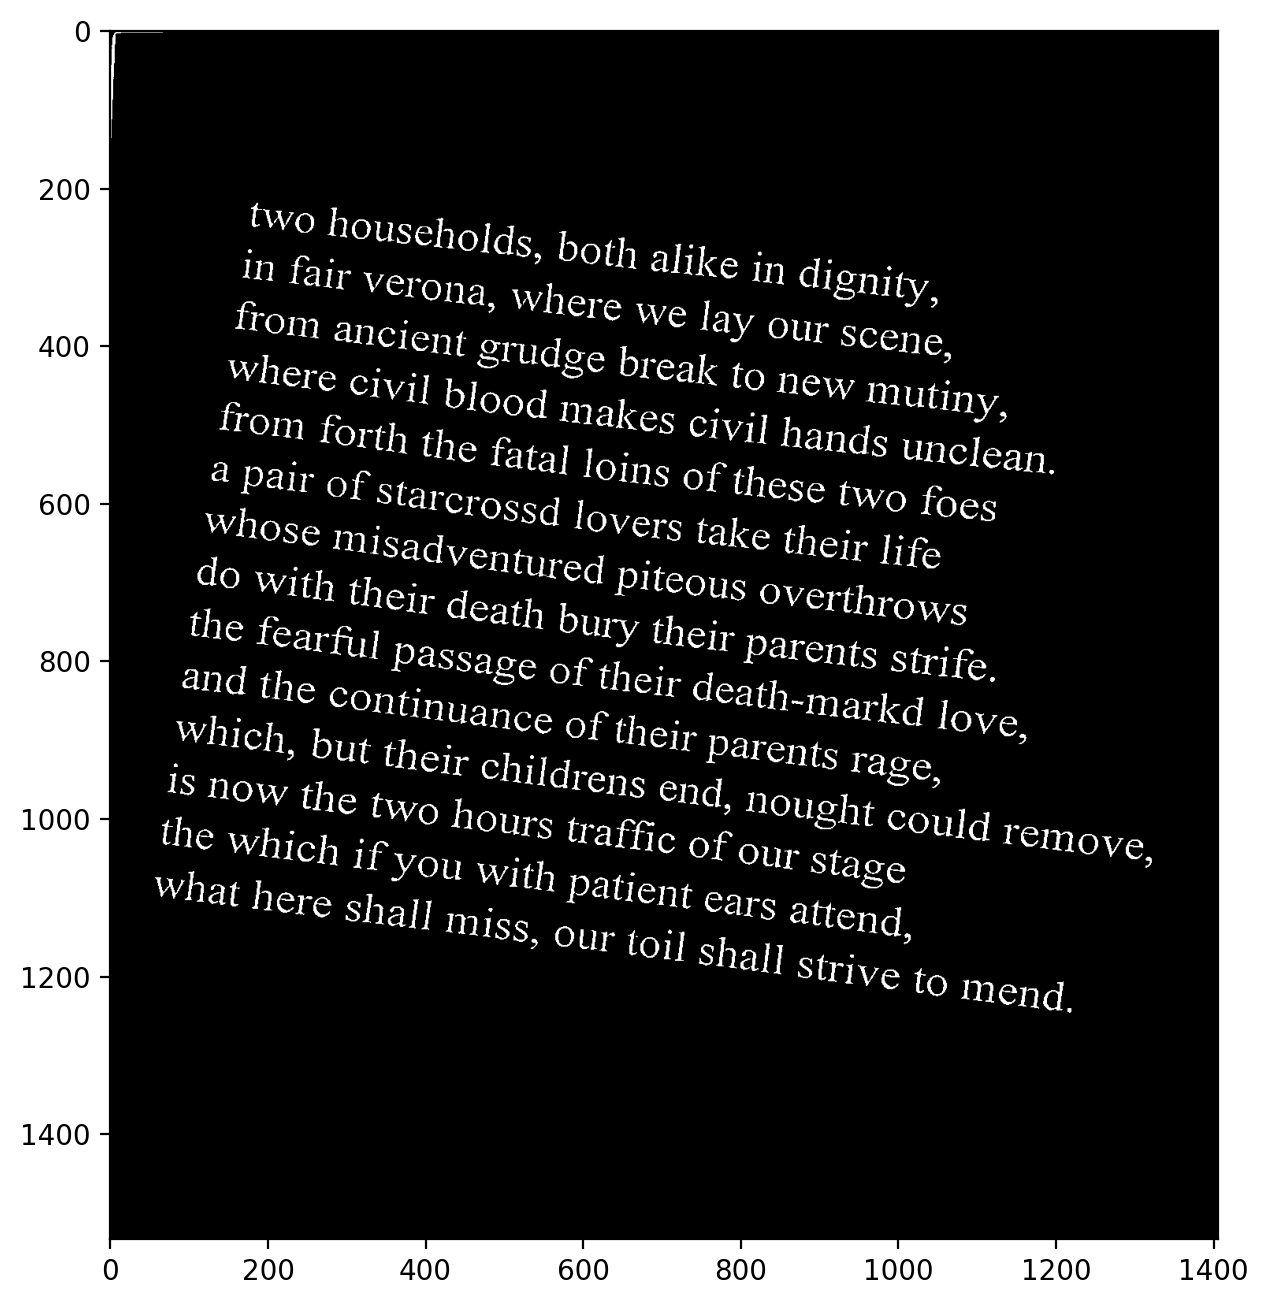

In [8]:
rows_sum = np.sum(blurred, axis=1) / 255
rows_peaks = np.column_stack(np.where(rows_sum > (img.shape[1] // 3)))
if len(rows_peaks) >= 6:
    start, end = np.min(rows_peaks), np.max(rows_peaks)
    img = img[start + 20:end - 20]

cols_sum = np.sum(blurred, axis=0) / 255
cols_peaks = np.column_stack(np.where(cols_sum > (img.shape[0] // 3)))
if len(cols_peaks) >= 6:
    start, end = np.min(cols_peaks), np.max(cols_peaks)
    img = img[:, start + 20:end - 20]

plt.imshow(img, cmap='gray')
plt.show()

Obraz mógł zostać krzywo zeskanowany. Obracam go zatem wykorzystując sumę pikseli po wierszach obrazu. Poprawnie obrócony obraz powinien mieć jak największą wariancję tej sumy (gdyż na wykresie powinno być widać wyraźne piki dla kolejnych linii tekstu). Sprawdzam zatem kąty od -45 stopni do 45 stopni i wybieram ten, dla którego wariancja była największa.

Angle: 7 deg


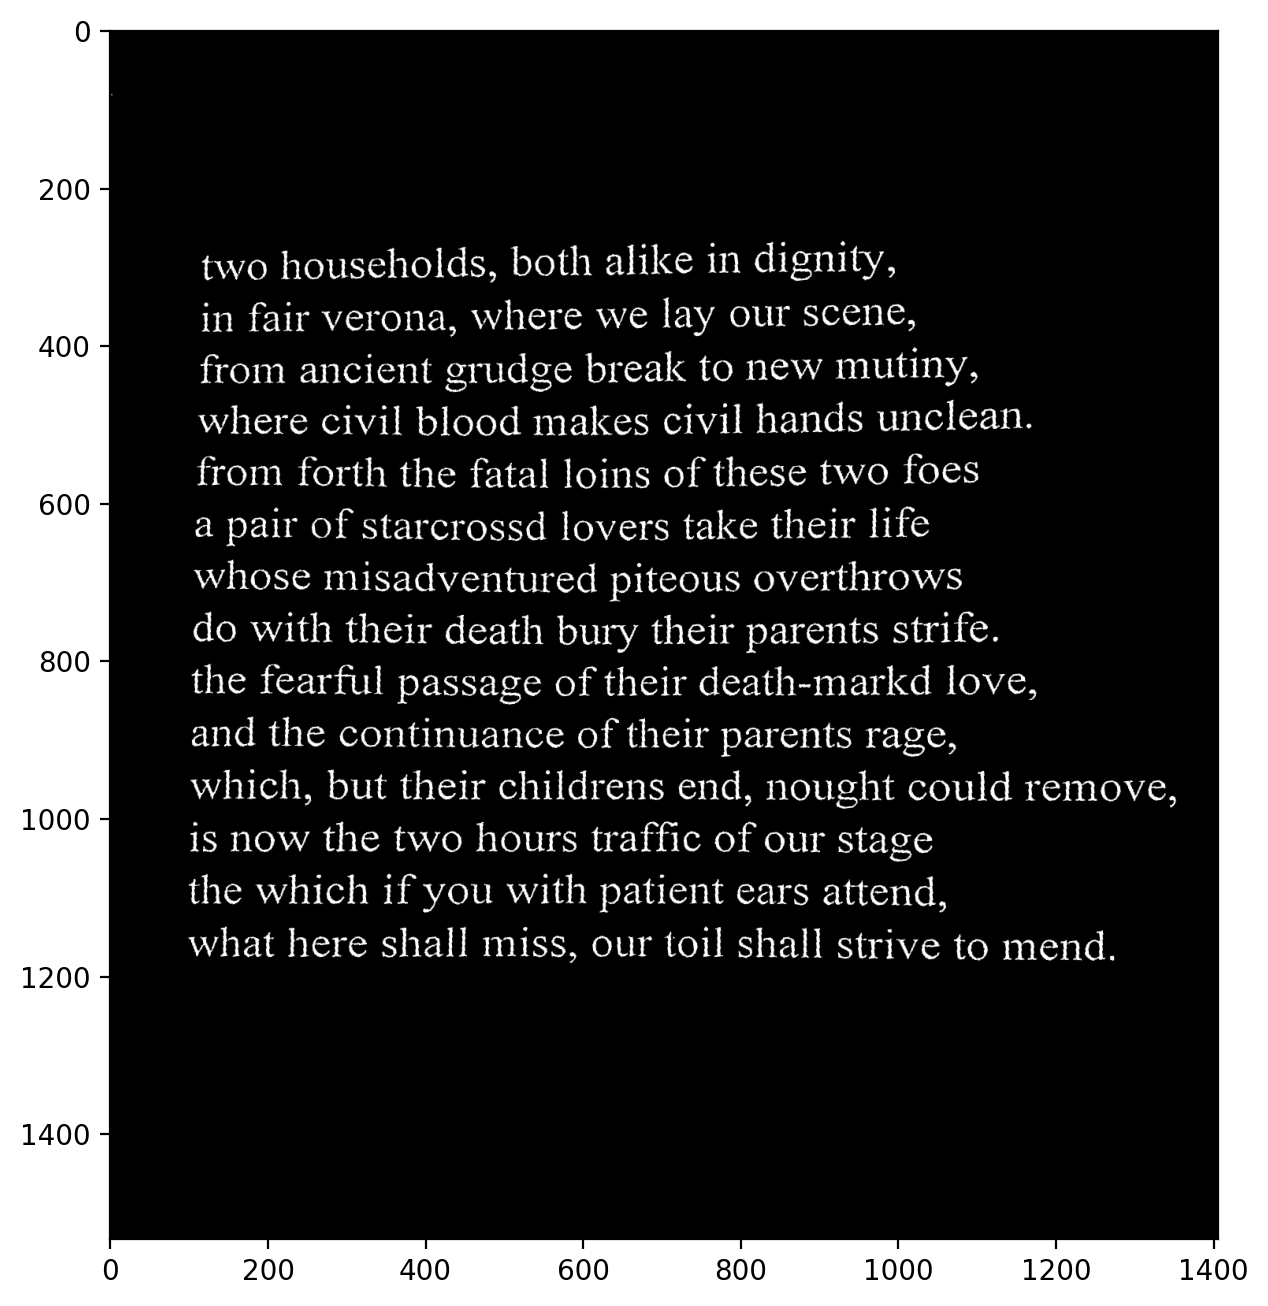

In [9]:
center = (img.shape[1] // 2, img.shape[0] // 2)
best_angle, best_val = 0, 0

for angle in range(-45, 46, 1):
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(img, M, img.shape[::-1], flags=cv2.INTER_LINEAR)
    result = np.var(np.sum(rotated, axis=1))

    if result > best_val:
        best_val = result
        best_angle = angle

M = cv2.getRotationMatrix2D(center, best_angle, 1.0)
img = cv2.warpAffine(img, M, img.shape[::-1], flags=cv2.INTER_LINEAR)

print(f'Angle: {best_angle} deg')
plt.imshow(img, cmap='gray')
plt.show()

# Segmentacja

Tekst na obrazie może mieć wiele linii. Ponieważ wykrycie podziału na linie za pomocą klasycznego rozpoznawania pojedynczych znaków mogłoby być trudne, dzielę najpierw tekst na linie. Wadą tej metody jest to, iż tekst, w którym występuje większa przerwa, zostanie zintepretowany z jednym znakiem nowej linii.

Stosuję podział w oparciu o ilość podświetlonych pikseli w danym wierszu obrazu oraz analizę powstałego wykresu. Ponieważ metoda ta może być bardzo podatna na szum na obrazie, ponownie stosuję silne rozmycie obrazu, aby w łatwy sposób wyróżnić poszczególne linie.

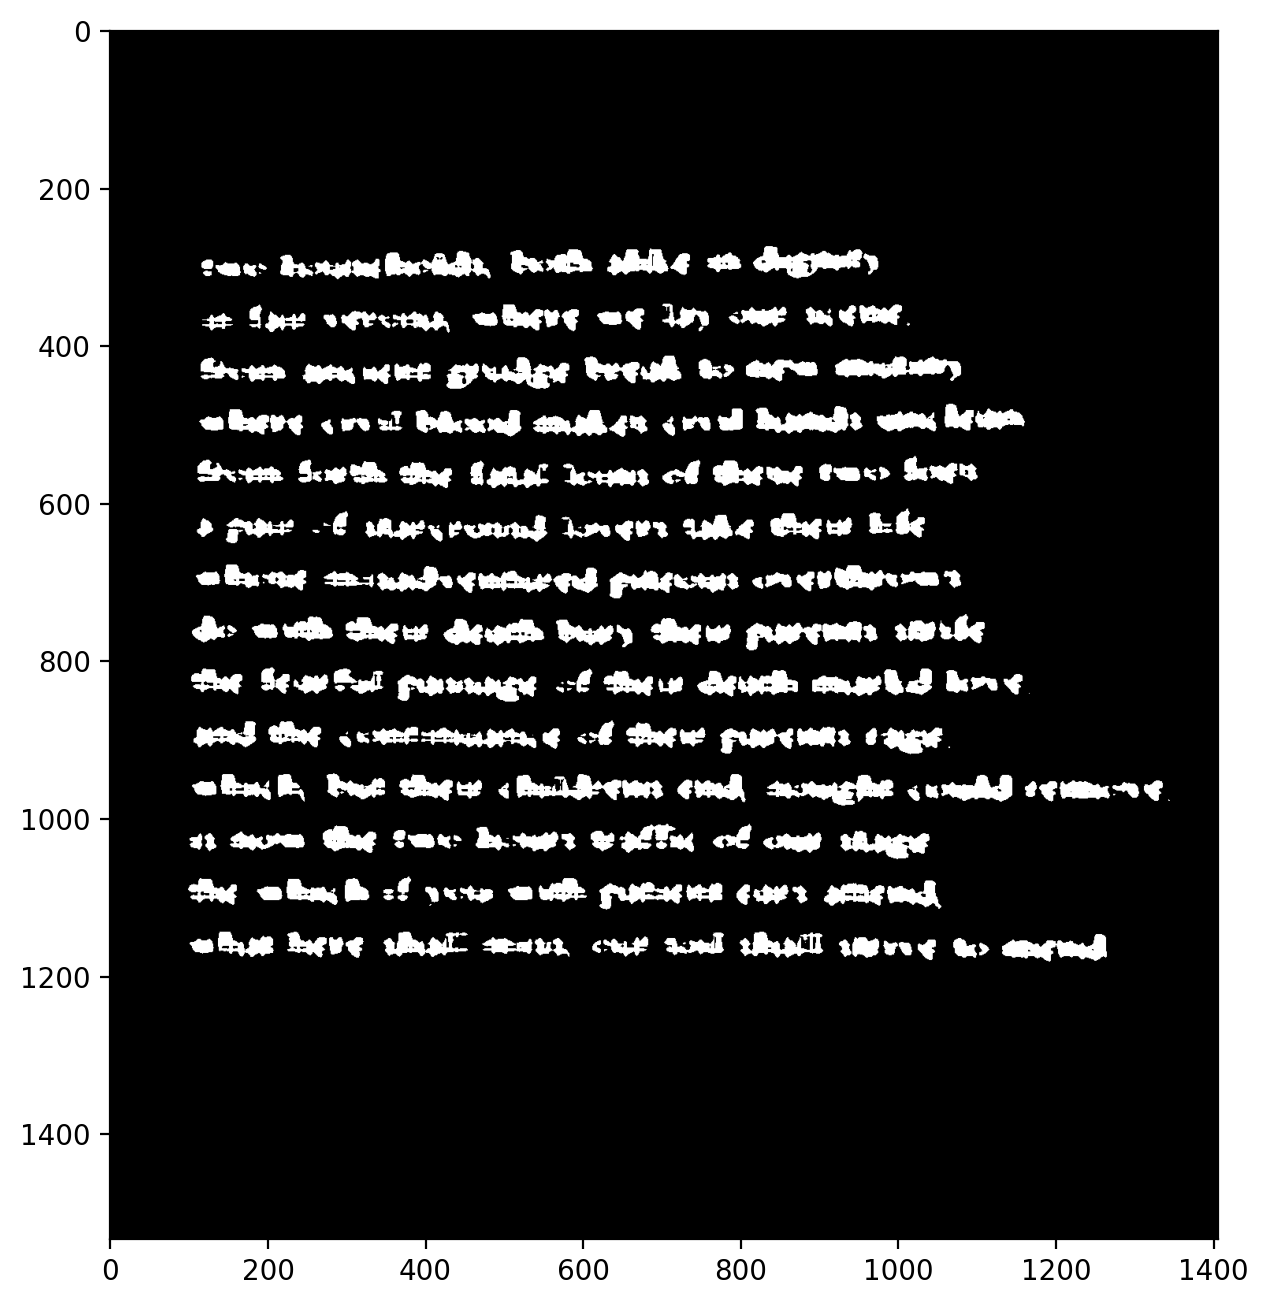

In [10]:
blurred = cv2.GaussianBlur(img, (17, 17), 17)
_, blurred = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY)

plt.imshow(blurred, cmap='gray')
plt.show()

Tak wygląda wykres otrzymany z rozmytego obrazu. Z łatwością można z niego odczytać położenie linii.

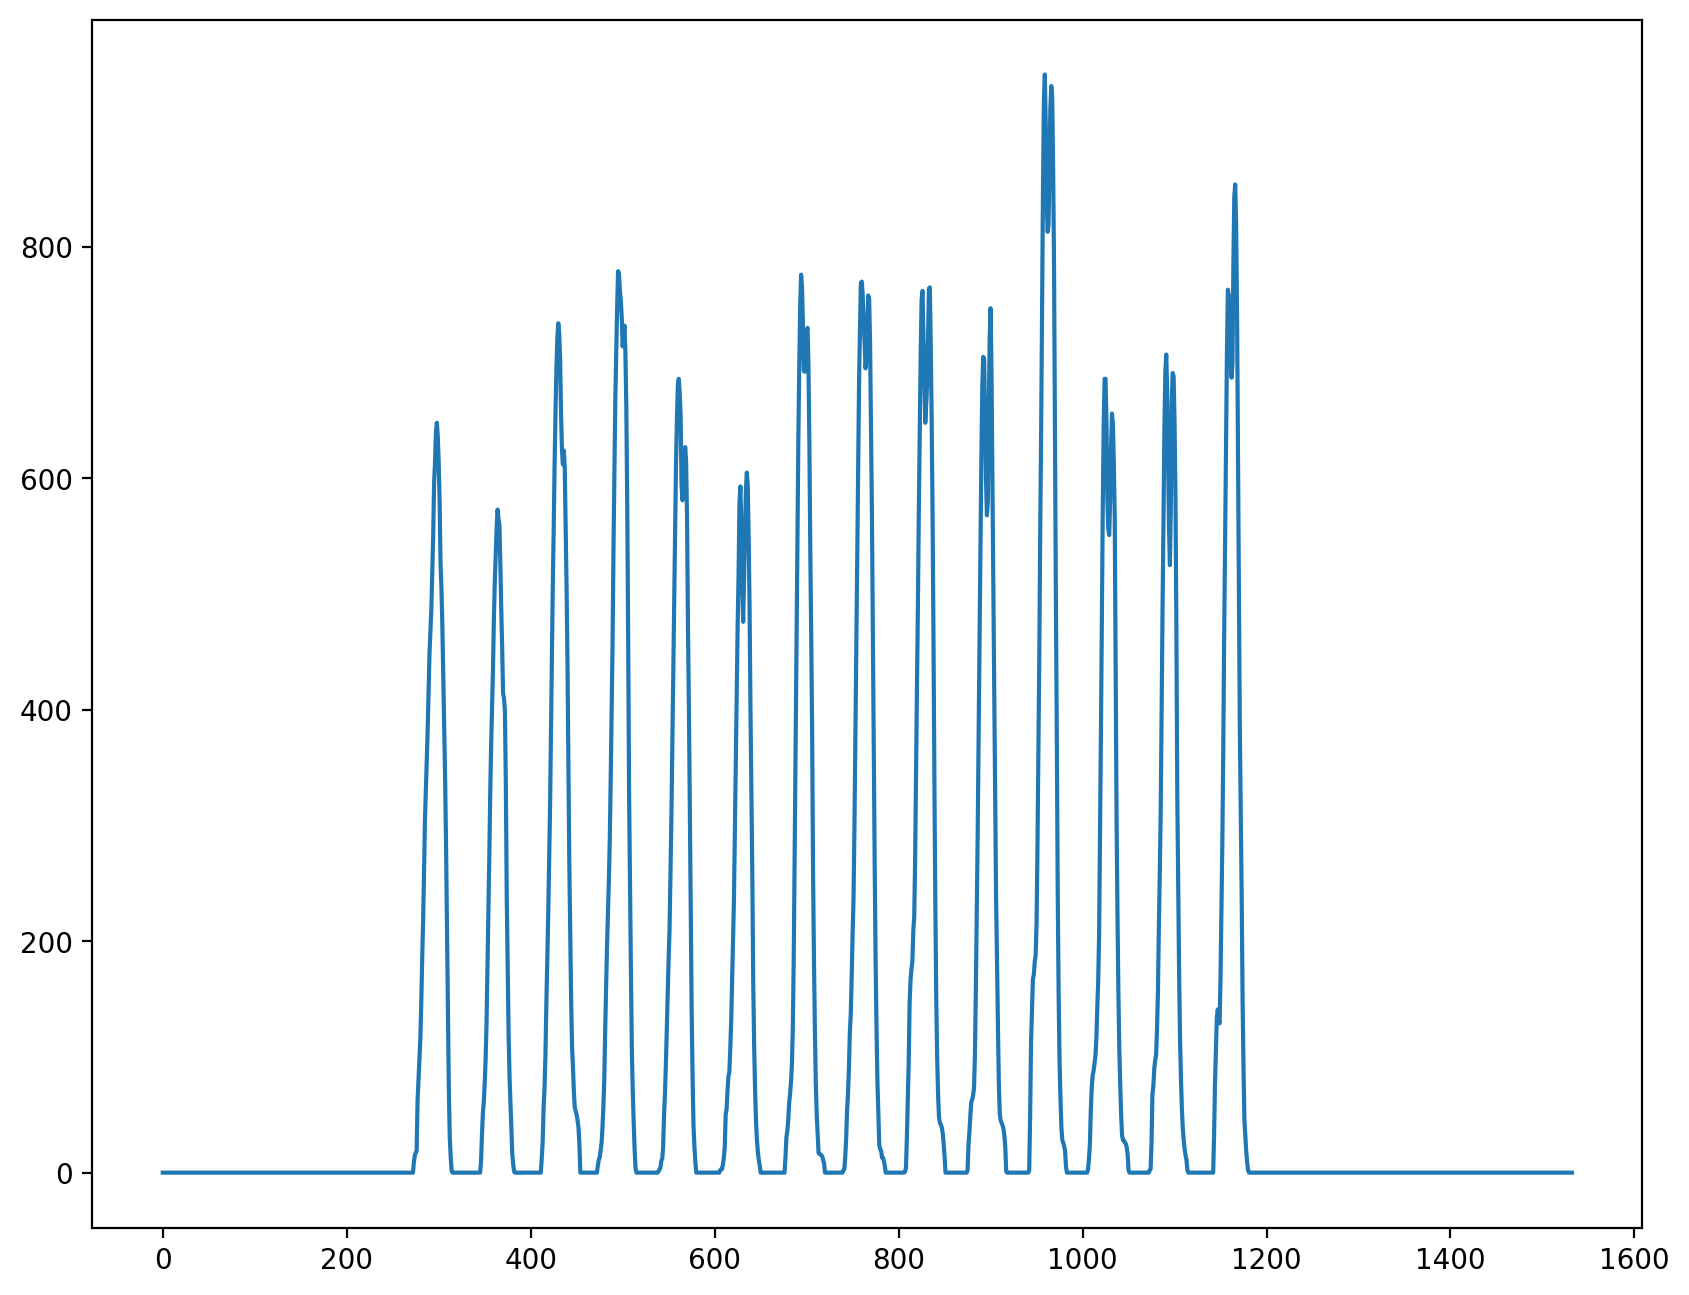

In [11]:
rows_sum = np.sum(blurred, axis=1)
plt.plot(rows_sum / 255)
plt.show()

Definiuję teraz metodę `split_rows`, która na podstawie ilości podświetlonych pikseli w wierszach wyznaczy podział obrazu. Funkcja w pierwszej kolejności rozmywa obraz, dokonuje binaryzacji oraz wyznacza sumę pikseli po wierszach. Na podstawie tej sumy oraz obliczonej wartości `tr_val`, dokonuje ona podziału obrazu. Zwraca podział w formie listy początków oraz końców przedziałów.

In [12]:
def find_intervals(points_sum, tr_val, padding):
    elements = []
    i = 0

    while i < len(points_sum):
        if points_sum[i] >= tr_val:
            start = i

            while i < len(points_sum) - 1 and points_sum[i] >= tr_val:
                i += 1

            end = i
            size = end - start

            if padding:
                start = max(0, int(start - size / 4))
                end = min(len(points_sum) - 1, int(end + size / 4))

            elements.append((start, end))

        i += 1

    return elements


def split_rows(source, blur_val=15):
    source = cv2.GaussianBlur(source, (blur_val, blur_val), blur_val)
    _, source = cv2.threshold(source, 40, 255, cv2.THRESH_BINARY)

    rows_sum = np.sum(source, axis=1) / 255
    tr_val = source.shape[1] / 20

    return find_intervals(rows_sum, tr_val, True)


Oto przykładowe dwie kolejne linie wyznaczone za pomocą funkcji `split_rows`:

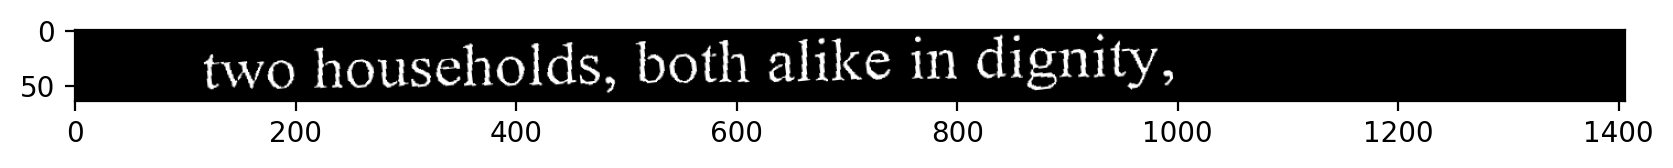

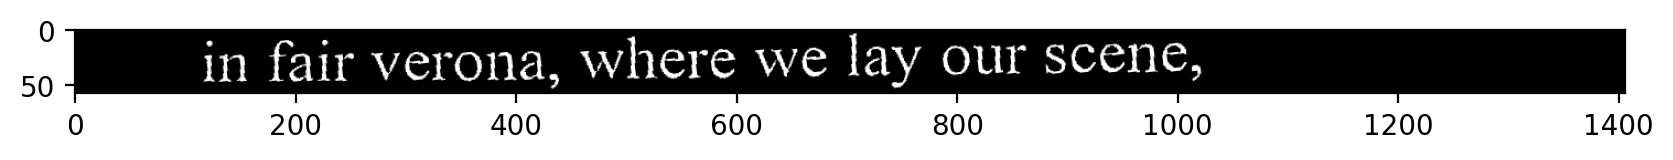

In [13]:
row_1 = split_rows(img)[0]
row_1 = img[row_1[0]:row_1[1]]
plt.imshow(row_1, cmap='gray')
plt.show()

row_2 = split_rows(img)[1]
row_2 = img[row_2[0]:row_2[1]]
plt.imshow(row_2, cmap='gray')
plt.show()

Odczytanie spacji za pomocą rozpoznawania pojedynczych znaków również mogłoby być trudne, dlatego w analogiczny sposób dokonam podziału wierszy na słowa. Tak jak wyżej, wadą rozwiązania jest pomijanie szerokich białych znaków w tekście, jednak takie podejście znacznie uprości rozpoznanie na obrazie odstępów.

Wykorzystuję do tego funkcję `split_words`, w której zastosuję rozmycie i poruszenie obrazu oraz, podobnie jak wyżej, sumę podświetlonych pikseli w kolumnach.

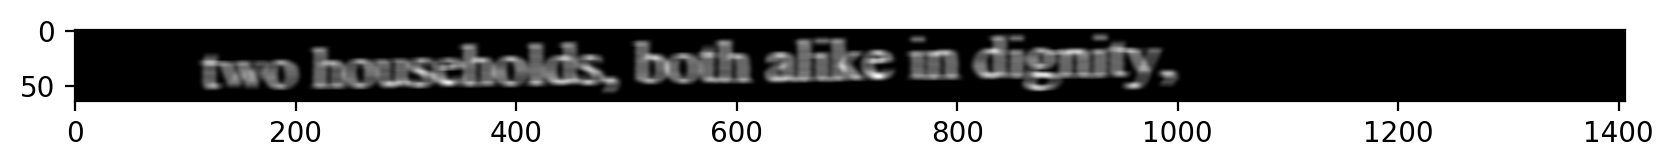

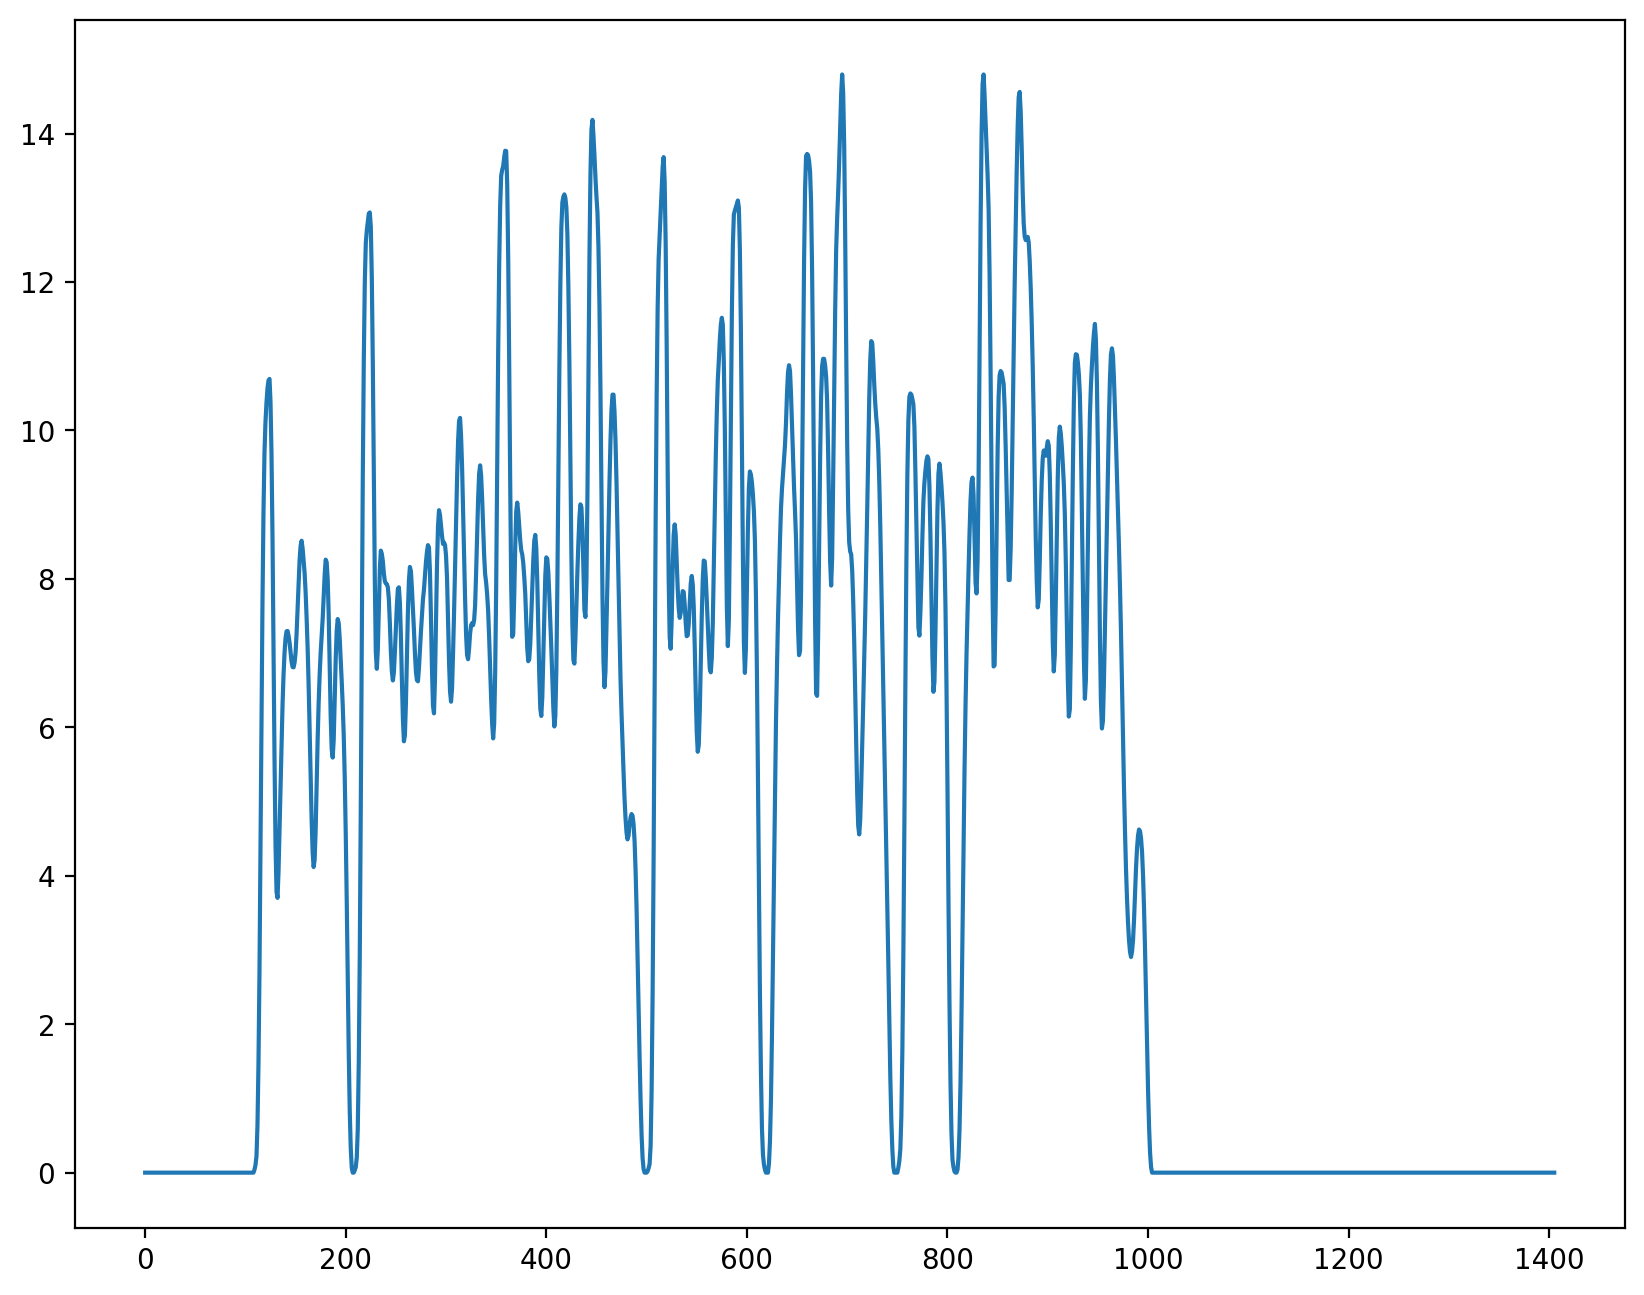

In [14]:
blurred = cv2.GaussianBlur(row_1, (5, 5), 5)

kernel_motion_blur = np.zeros((13, 13))
kernel_motion_blur[6, :] = 1 / 13
blurred = cv2.filter2D(blurred, -1, kernel_motion_blur)

plt.imshow(blurred, cmap='gray')
plt.show()

row_sum = np.sum(blurred, axis=0)
plt.plot(row_sum / 255)
plt.show()

In [15]:
def split_words(source):
    source = cv2.GaussianBlur(source, (5, 5), 5)
    source = cv2.filter2D(source, -1, kernel_motion_blur)

    cols_sum = np.sum(source, axis=0) / 255
    tr_val = source.shape[0] / 20

    return find_intervals(cols_sum, tr_val, False)

Przykładowe wyrazy uzyskane za pomocą funkcji `split_words`:

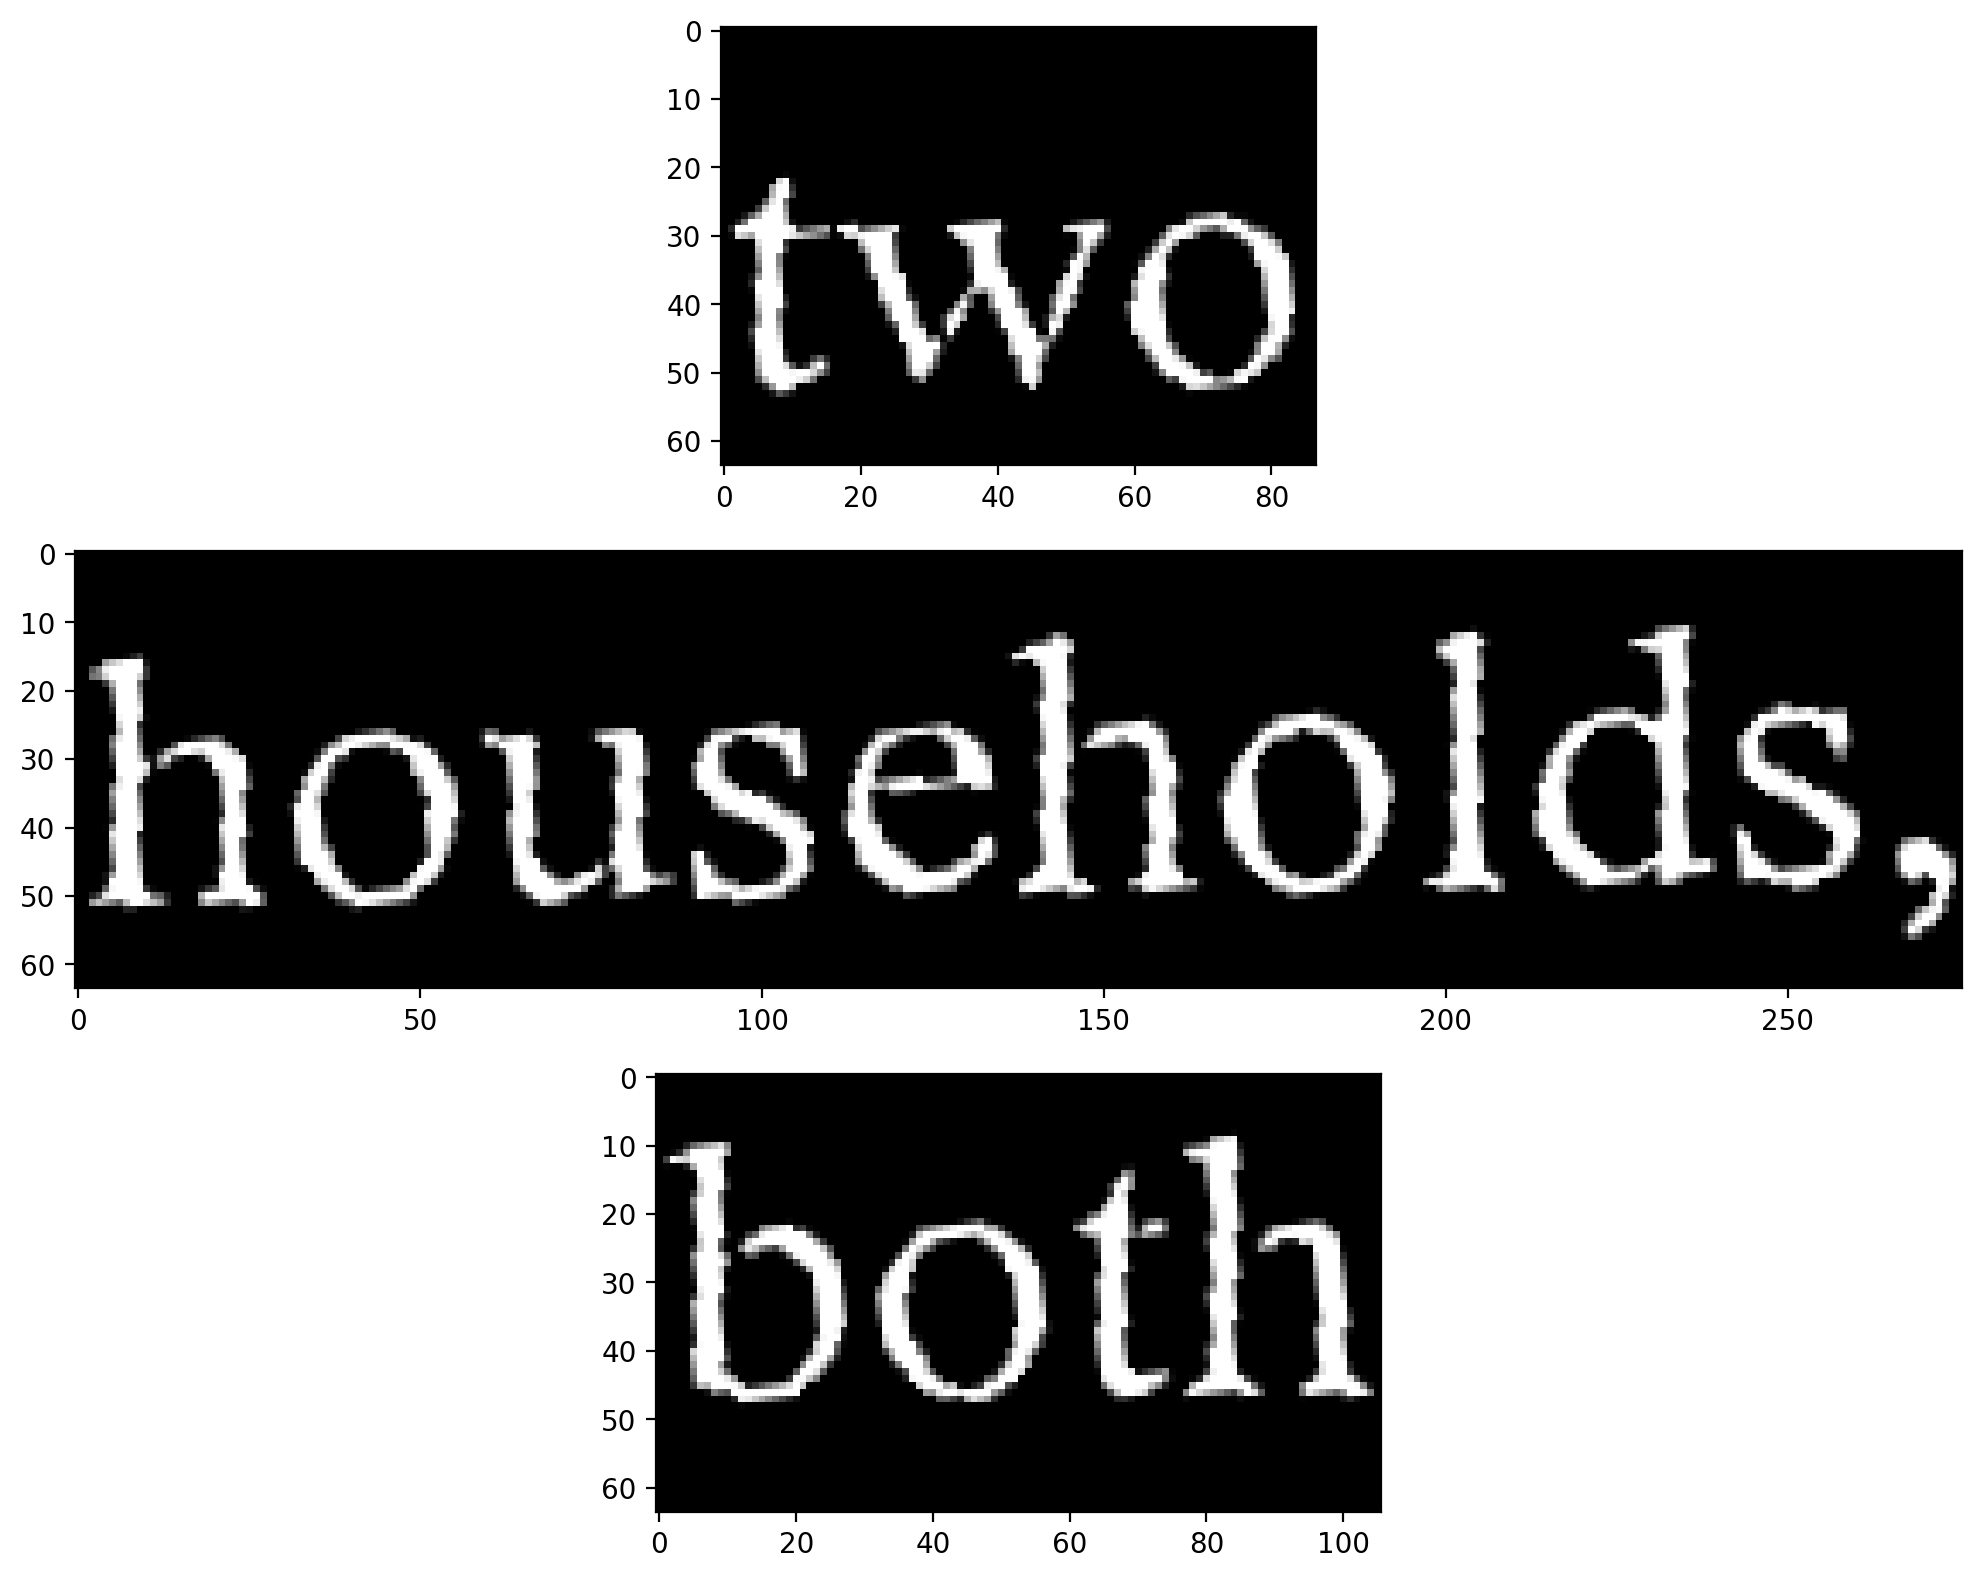

In [16]:
word_1 = split_words(row_1)[0]
word_1 = row_1[:, word_1[0]:word_1[1]]

word_2 = split_words(row_1)[1]
word_2 = row_1[:, word_2[0]:word_2[1]]

word_3 = split_words(row_1)[2]
word_3 = row_1[:, word_3[0]:word_3[1]]

_, ax = plt.subplots(3)
ax[0].imshow(word_1, cmap='gray')
ax[1].imshow(word_2, cmap='gray')
ax[2].imshow(word_3, cmap='gray')
plt.tight_layout()
plt.show()

Ostatnim etapem segmentacji, będzie podział słów na znaki. Użyję do tego celu wyznaczania silnie spójnych składowych na obrazie pojedynczego słowa.

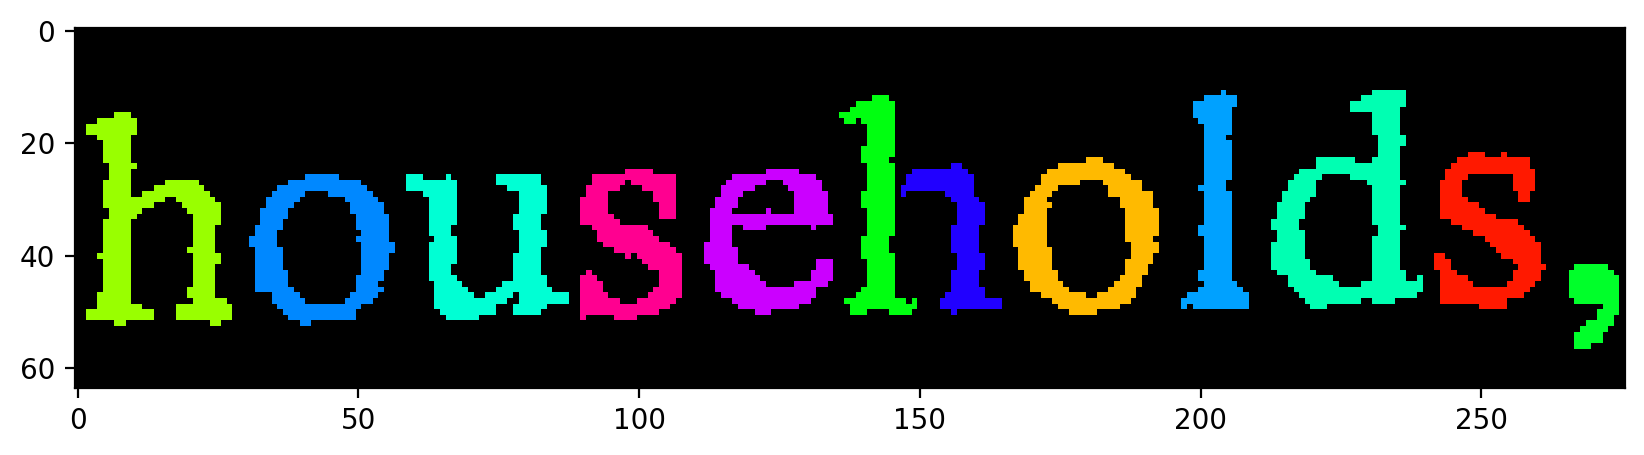

In [17]:
labels_count, labeled_img = cv2.connectedComponents(word_2)

labeled_hue = np.uint8(255 * labeled_img / labels_count)
blank = 255 * np.ones(labeled_hue.shape, dtype=np.uint8)
labeled_img = cv2.merge([labeled_hue, blank, blank])
labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
labeled_img[labeled_hue == 0] = 0

plt.imshow(labeled_img)
plt.show()

Poniżej znajduje się funkcja realizująca podział z użyciem silnie spójnych składowych. Używam funkcji `connectedComponentsWithStats`, która pozwala na łatwe odczytanie przedziałów kolumn dla znalezionych znaków na obrazie. Ponieważ zdarza się, iż jeden znak z natury zawiera dwie składowe (np. kropka nad "i"), funkcja "skleja" zachodzące na siebie przedziały. Zwraca wynik w postaci listy początków i końców przedziałów.

In [18]:
def split_chars(word):
    _, _, stats, _ = cv2.connectedComponentsWithStats(word, 8)
    positions = [[s[cv2.CC_STAT_LEFT], s[cv2.CC_STAT_LEFT] + s[cv2.CC_STAT_WIDTH]] for s in stats]
    positions.sort(key=lambda x: x[0])

    if len(positions) <= 1:
        return []

    stack = [positions[1]]
    for i in range(2, len(positions)):
        last = stack.pop()

        if last[1] > positions[i][0]:
            last[1] = max(positions[i][1], last[1])
            stack.append(last)
        else:
            stack.append(last)
            stack.append(positions[i])

    return stack

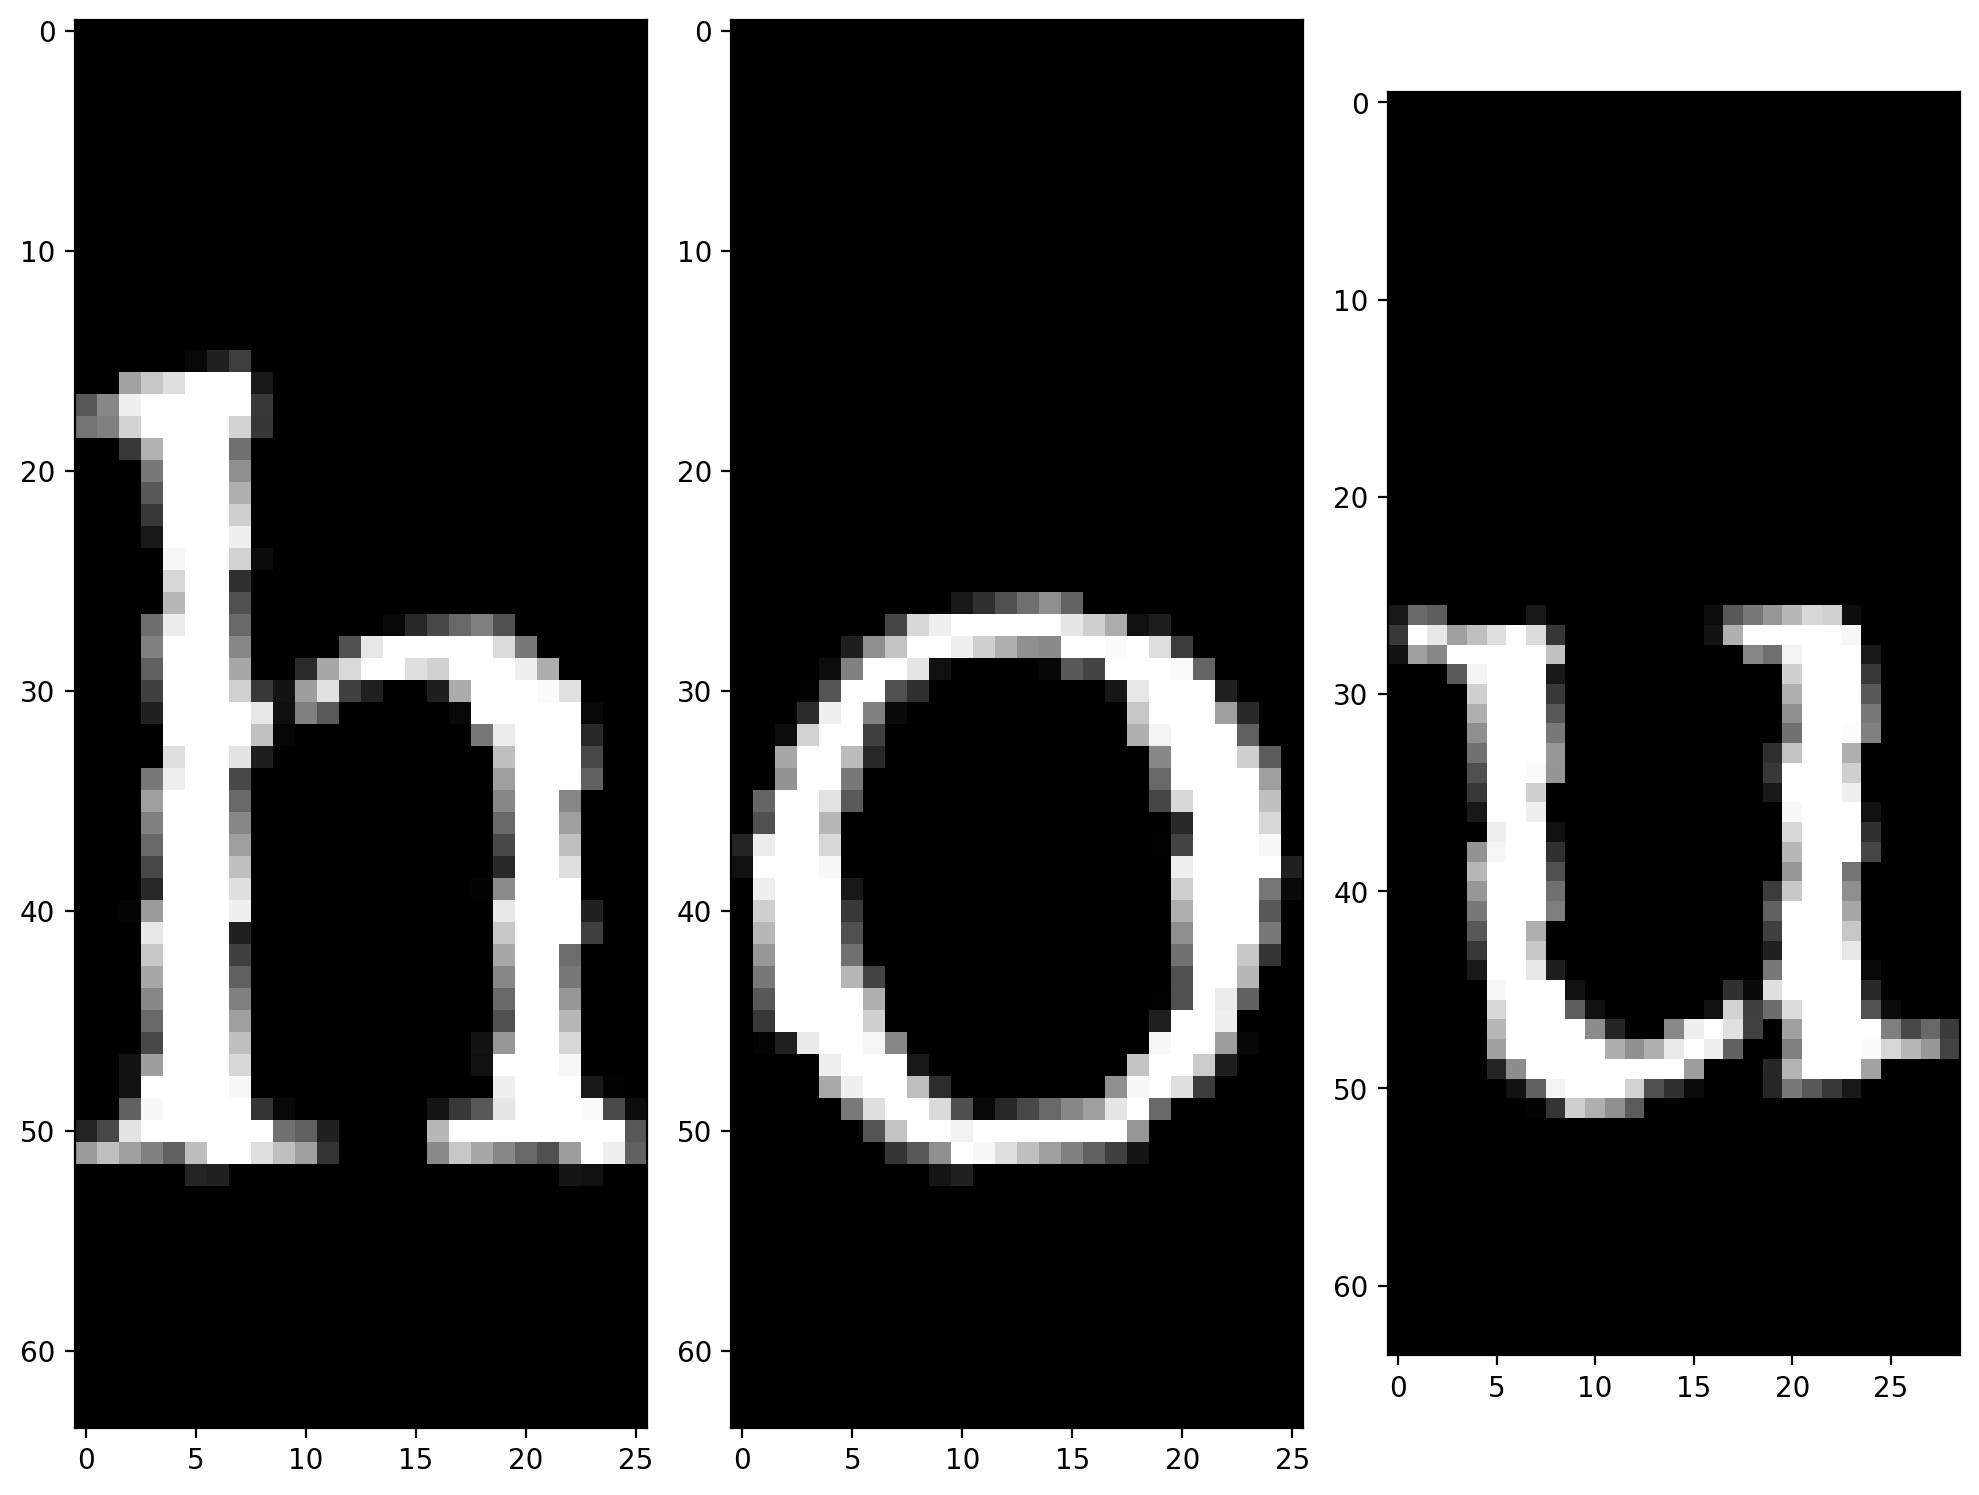

In [19]:
char_1 = split_chars(word_2)[0]
char_1 = word_2[:, char_1[0]:char_1[1]]

char_2 = split_chars(word_2)[1]
char_2 = word_2[:, char_2[0]:char_2[1]]

char_3 = split_chars(word_2)[2]
char_3 = word_2[:, char_3[0]:char_3[1]]

_, ax = plt.subplots(1, 3)
ax[0].imshow(char_1, cmap='gray')
ax[1].imshow(char_2, cmap='gray')
ax[2].imshow(char_3, cmap='gray')
plt.tight_layout()
plt.show()

# Rozpoznawanie znaków

## DFT

Etap ten rozpocząłem od przygotowania obrazu ze wzorcowymi znakami. Uwzględniłem małe litery łacińskiego alfabetu, cyfry oraz znaki przestankowe.

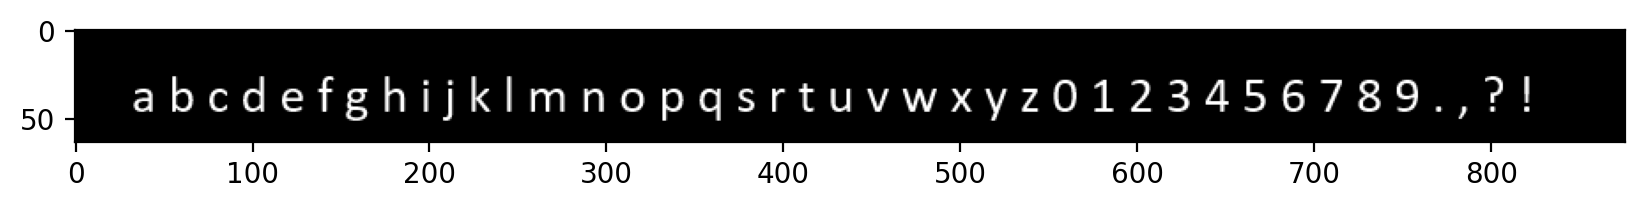

In [20]:
with open('texts/alphabet.txt', encoding='utf-8') as file:
    alphabet_text = file.read().split()

alphabet_img = cv2.imread('images/alphabet.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(alphabet_img, cmap='gray')
plt.show()

Poszczególne znaki wyodrębniam z obrazu oraz zapisuję w liście jako pary (obraz, znak).

In [21]:
rows = split_rows(alphabet_img)
alphabet = []
i = 0

for r_start, r_end in rows:
    row = alphabet_img[r_start:r_end]
    chars = split_chars(row)

    for c_start, c_end in chars:
        char_img = row[:, c_start:c_end]
        alphabet.append((char_img, alphabet_text[i]))

        i += 1

Poniżej znajduje się funkcja, która dopasowuje znak do danego obrazu. Przegląda ona wszystkie znaki z listy `alphabet`, dopasowuje rozmiar wzorca do podanego obrazu oraz wylicza maksymalną wartości funkcji korelacji ze wzorcem (za pomocą DFT i operacji splotu). Funkcja zwraca znak, którego wartość funkcji korelacji jest najbliższa korelacji znaku z samym sobą.

In [22]:
def img_to_text_dft(char):
    best_match = [float('inf'), '']
    f_value = np.max(ifft2(fft2(char) * fft2(rot90(char, 2))).real)

    for char_img, char_text in alphabet:
        scale = char.shape[1] / char_img.shape[1]
        char_img = cv2.resize(char_img, (0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)

        correlation = ifft2(fft2(char) * fft2(rot90(char_img, 2), char.shape)).real
        result = np.abs(f_value - np.max(correlation))

        if result < best_match[0]:
            best_match[0] = result
            best_match[1] = char_text

    return best_match[1]

## SVM

Zaimplementowałem również drugą technikę rozpoznawania znaków na obrazie, a więc klasyfikację z wykorzystaniem SVM. Stworzyłem obraz składający się ze znaków w 23 różnych czcionkach, który użyję później do trenowania modelu. Czcionki różnią się grubością, szerokością, wielkością, kształtem oraz rodzajem (szeryfowe/bezszeryfowe). Wybrałem różnorodne czcionki, aby ulepszyć przewidywania klasyfikatora oraz poszerzyć możliwości skanera na różnego rodzaju teksty.

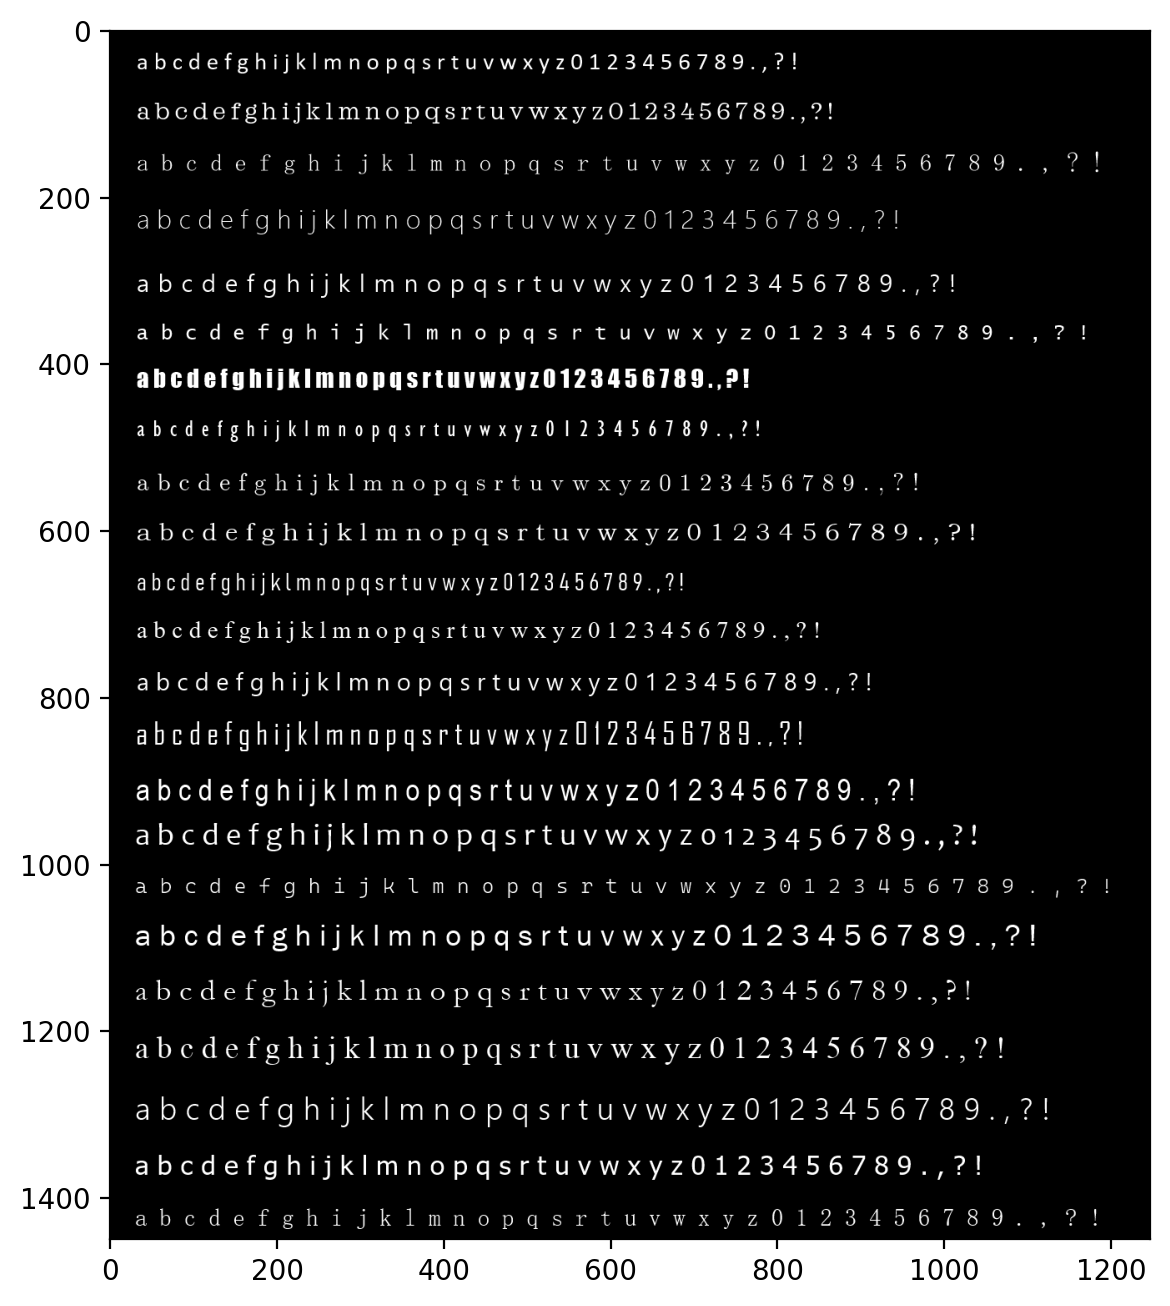

In [23]:
with open('texts/alphabet_big.txt', encoding='utf-8') as file:
    alphabet_text = file.read().split()

alphabet_img = cv2.imread('images/alphabet_big.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(alphabet_img, cmap='gray')
plt.show()

Wektory klasyfikowane przez SVM muszą mieć ten sam rozmiar, zatem poniżej podaję funkcję, która przetwarza wejściowy obraz (ze znakiem) na kwadratowy obraz o domyślnych wymiarach (90, 90), w którego środku będzie znajdował się przekazany obraz.

In [24]:
def standard_resize(img, size=90):
    if img.shape[1] > img.shape[0]:
        height = int(img.shape[0] * size / img.shape[1])
        img = cv2.resize(img, (size, height), interpolation=cv2.INTER_LINEAR)
    else:
        width = int(img.shape[1] * size / img.shape[0])
        img = cv2.resize(img, (width, size), interpolation=cv2.INTER_LINEAR)

    top_border = (size - img.shape[0]) // 2
    bottom_border = size - img.shape[0] - top_border
    left_border = (size - img.shape[1]) // 2
    right_border = size - img.shape[1] - left_border

    return cv2.copyMakeBorder(img, top_border, bottom_border, left_border, right_border, cv2.BORDER_CONSTANT, value=0)

Wycinam z obrazu poszczególne znaki i trenuję na ich podstawie klasyfikator SVM.

In [25]:
rows = split_rows(alphabet_img, 5)
alphabet_big = []

for r_start, r_end in rows:
    row = alphabet_img[r_start:r_end]
    chars = split_chars(row)

    for c_start, c_end in chars:
        char = row[:, c_start:c_end]
        char = standard_resize(char)
        alphabet_big.append(char.flatten())

classifier = svm.SVC()
classifier.fit(alphabet_big, alphabet_text)

SVC()

In [26]:
def img_to_text_svm(char):
    char = standard_resize(char)
    return classifier.predict([char.flatten()])[0]

Funkcja `ocr` jest odpowiedzialna za przetworzenie obrazu (który został wcześniej poddany preprocessingowi) na tekst. Przeprowadza ona podział obrazu na linie, słowa oraz litery, a następnie odczytuje poszczególne znaki za pomocą funkcji przekazanej jako parametr i zwraca otrzymany tekst.

In [27]:
def ocr(image, img_to_text):
    rows = split_rows(image)
    text = ''

    for r_start, r_end in rows:
        row = image[r_start:r_end]
        words = split_words(row)

        for w_start, w_end in words:
            word = row[:, w_start:w_end]
            chars = split_chars(word)

            for c_start, c_end in chars:
                text += img_to_text(word[:, c_start:c_end])

            text += ' '
        text += '\n'

    return text

# Testy zbudowanego systemu OCR

Jakość tekstu wygenerowanego przez OCR postanowiłem zmierzyć odległością Levenshteina. Poniższa funkcja zwraca podobieństwo dwóch tekstów obliczone w oparciu o tę metrykę (im wynik bliższy 1, tym teksty bardziej podobne; im bliższy 0, tym teksty bardziej się różnią).

In [28]:
def levenshtein(original, ocr_text):
    delta = lambda x, y: 0 if x == y else 1
    n, m = len(original), len(ocr_text)

    edit = np.zeros((2, m + 1), dtype=np.int32)
    edit[0, :] = np.arange(m + 1)
    edit[1, 0] = 1

    for i, j in product(range(1, n + 1), range(1, m + 1)):
        edit[i % 2, j] = min(edit[(i - 1) % 2, j] + 1,
                             edit[i % 2, j - 1] + 1,
                             edit[(i - 1) % 2, j - 1] + delta(original[i - 1], ocr_text[j - 1]))

    return 1 - edit[n % 2, -1] / max(n, m)

Oto wynik działania programu dla przykładowego zdjęcia:

In [29]:
text_dft = ocr(img, img_to_text_dft)
print(text_dft)

qp bbksbbbik8! bpib aijke ib kig8i6 ! 
jb gjr yerdbal wgere we ja0 bur sbbbbi 
ada apjeni gi 4kge 6reak ip bew akjjg0l 
wbere bjy jj 6jpbk aakbs bjyjj ba9ks k9biba9 
adm gi iib jbe gtai ibjbs bf jbbse iwp gps 
a pajr qf sjarbrb8sk ibyers jake jbbjr jja 
wjdse i6jsgdvenjed pjjepk8 pybagrdw8 
kp wjjb jbeji keaig bk6 ibeii pabnj8 8aju 
jbe aai gi passagb df jbeii kbajbb ! markk jpye! 
ab8 jge bpnjjnuanpe df jgejr parenjs rggbi 
wbibii! bui i6eii bkiidrebs bgd! bbggbj bb6ik rbadyb! 
ls bbw jbb twd bdgrs jragb bf bur stagb 
jbb wbjbb if 0dk wijb pajieirj ears agbgk! 
wbai bere shaii i6iss! pili jpii sbaii 8ji zjyb jd aegk 



In [30]:
text_svm = ocr(img, img_to_text_svm)
print(text_svm)

go houscholds, both alik0 l0 0lg0!g . 
in mit vcrona, whcrc w0 l0y 00t 50000. 
bom gcicnt gt udgc btcak t0 n0w m0l!0x. 
whcrc civ il blood makcs civil hauda 000l040 
wom mt .th the mtal loins of thcsc two m08 
a pait of starcrossd lovcrs takc thcit lim 
w0050 1bl8advcngcd pitc0us 0v0d0r0w8 
do with thcit dcath bug thcit pucnts swim 
thc mat ml passagc of thcit dcath. . markd lovc, 
80d l00 000ll0uuucc of tb0it purcnts rag0, 
whicli, but thcit childrcns cnd, uought could rcmovc, 
is now thc two hours tragc of out stage 
thc which if you with palici1t cars ahcnd, 
what hcrc shall iriss, ortt toil shall stt .ive to mend 



In [31]:
with open('texts/romeo_and_juliet.txt', encoding='utf-8') as file:
    text = file.read()
    print(f'OCR with DFT accuracy: {levenshtein(text, text_dft):.0%}')
    print(Counter(text_dft))
    print(f'OCR with SVM accuracy: {levenshtein(text, text_svm):.0%}')
    print(Counter(text_svm))

OCR with DFT accuracy: 47%
Counter({' ': 114, 'b': 84, 'j': 57, 'i': 55, 'a': 42, 'e': 36, 'g': 27, 'k': 25, 's': 24, 'r': 24, 'p': 21, 'd': 16, '\n': 14, 'w': 14, '8': 9, '!': 9, '6': 8, 'y': 8, 'n': 7, 'f': 6, 'u': 5, 'l': 4, '0': 3, '9': 3, 't': 3, 'q': 2, 'm': 2, '4': 1, 'v': 1, 'h': 1, 'z': 1})
OCR with SVM accuracy: 70%
Counter({' ': 114, 't': 53, 'c': 51, '0': 39, 'i': 33, 'h': 32, 'o': 31, 'l': 29, 'a': 27, 's': 25, 'd': 18, 'r': 18, 'u': 17, 'w': 16, 'm': 15, '\n': 14, 'g': 13, 'n': 13, ',': 9, 'v': 9, 'b': 8, '.': 7, 'f': 6, 'p': 6, 'k': 5, 'e': 4, '8': 4, '!': 2, 'y': 2, '5': 2, '1': 2, 'x': 1, '4': 1})


Z powyższego kodu utworzyłem skrypt `ocr.py`, który posłużył mi do przetestowania działania programu na różnych obrazach. Jego argumentami jest ścieżka do obrazu oraz ewentualnie ścieżka do oryginalnego tekstu dla porównania. Skrypt zwraca odczytany tekst oraz dokładność, jeśli podany został tekst oryginalny. Można ustawić również flagę `--no-frame`, która powoduje, że w procesie pominięty zostanie etap wycinania ramki oraz korekcji perspektywy.

Przeprowadziłem testy dla trzech różnych tekstów ("Pan Tadeusz", "Lorem ipsum", "Romeo and Juliet"), każdy w trzech wersjach - zdjęcie wydrukowanego tekstu, przekrzywiony screenshot o średniej rozdzielczości oraz screenshot tekstu w wysokiej rozdzielczości. Z tekstów usunąłem polskie znaki, wielkie litery oraz znaki specjalne, których nie rozpoznaje mój program. Poniżej zamieszczam otrzymane wyniki w postaci procentowej dokładności metod dla poszczególnych obrazów:

**1. Pan Tadeusz**

|      Typ        |   DFT   |   SVM   |
|:---------------:|:-------:|:-------:|
| zdjęcie tekstu  |   46%   |   59%   |
| screenshot      |   błąd  |   błąd  |
| screenshot hres |   58%   |   79%   |

**2. Lorem ipsum**

|      Typ        |   DFT   |   SVM   |
|:---------------:|:-------:|:-------:|
| zdjęcie tekstu  |   36%   |   52%   |
| screenshot      |   40%   |   55%   |
| screenshot hres |   44%   |   59%   |

**3. Romeo and Juliet**

|      Typ        |   DFT   |   SVM   |
|:---------------:|:-------:|:-------:|
| zdjęcie tekstu  |   47%   |   70%   |
| screenshot      |   błąd  |   błąd  |
| screenshot hres |   44%   |   77%   |

# Wnioski

- Zautomatyzowane przetwarzanie obrazu od zdjęcia tekstu, aż do podziału na poszczególne znaki, daje zazwyczaj dobre rezultaty. Sporadycznie występują błędy, na przykład sklejenie dwóch znaków lub niepoprawny podział słów. Błędy te można zazwyczaj wyeliminować poprzez indywidualne dobranie parametrów programu do danego zdjęcia.
- Parametry zakodowane w programie zostały dobrane tak, aby otrzymać jak najlepsze rezultaty na testowanych obrazach. Aby skonstruowany OCR działał na jeszcze szerszej gamie zdjęć, można by zaimplementować dobór parametrów w zależności od obrazu na wejściu - myślę, że mogłoby to poprawić jakość uzyskiwanego wyniku na etapach preprocessingu oraz segmentacji.
- Rozpoznawanie znaków z użyciem DFT daje bardzo złe rezultaty, w większości przypadków nie jesteśmy w stanie domyślić się, jaki tekst znajdował się na skanowanym obrazie. Wyniki uzyskane przez OCR z DFT są w dużej mierze osiągane tylko przez poprawny podział na linie i słowa oraz w miarę dobrze dobraną ilość liter w każdym słowie. Sądzę, że technika ta mogłaby dawać lepsze rezultaty w rozpoznawaniu znaków, należałoby jednak zastosować inną metodę wyszukiwania poprawnego znaku.
- Ponieważ rozpoznawanie znaków z użyciem DFT nie dawało dobrych wyników, zaimplementowałem klasyfikację znaków w oparciu o SVM. Użycie tej metody spowodowało znaczny wzrost poprawności odczytywania tekstu z danych obrazów. W niektórych przypadkach, jesteśmy w stanie całkiem sprawnie domyślić się, jaki tekst był skanowany przez OCR.
- Jakość wyniku zależała w dużym stopniu od skanowanego tekstu - przykładowo zdjęcia z tekstem "Romeo and Juliet" uzyskiwały znacznie lepsze wyniki, niż te z "Lorem ipsum". Wynikać to może z wielkości tekstu (w "Romeo..." użyłem większego rozmiaru) oraz rodzaju czcionki.
- Kluczowe do uzyskania dobrych rezultatów, była wysoka rozdzielczość zdjęcia. Screenshot o średniej rozdzielczości w dwóch przypadkach wygenerował całkowicie błędny wynik.
- Co nie jest zaskakujące, komputerowy screenshot o wysokiej rozdzielczości wygenerował najlepsze teksty, prawdopodobnie ze względu na wysoką rozdzielczość znaków oraz "czysty" obraz.
- Aby poprawić rozpoznawanie znaków, można by zastosować bardziej zaawansowane techniki, na przykład sieci neuronowe. Myślę, że ten czynnik mógłby najbardziej wpłynąć na jakość generowanego tekstu, gdyż właśnie rozpoznawanie pojedynczych znaków było najbardziej problematyczne w moim programie.